# Skin Cancer Detection

This project focuses on using various Python machine learning and data-science libraries in an attempt to build machine learning model capable of predicting whether or not a patient's skin lesion is one of the six types of skin disease in this multi-classification problem.

Project approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem definition
In a statement:
> Predict whether a skin lesion is Basal Cell Carcinoma (BCC), Squamous Cell Carcinoma (SCC), Actinic Keratosis (ACK), Seborrheic Keratosis (SEK), Melanoma (MEL), and/or Nevus (NEV) given smartphone images of unique skin lesions of patients and information about the patient.

## 2. Data
The PAD-UFES-20 dataset was collected along with the Dermatological and Surgical Assistance Program (in Portuguese: Programa de Assistência Dermatológica e Cirurgica - PAD) at the Federal University of Espírito Santo (UFES-Brazil), which is a nonprofit program that provides free skin lesion treatment, in particular, to low-income people who cannot afford private treatment.

https://data.mendeley.com/datasets/zr7vgbcyr2/1 

## 3. Evaluation
> The project's success will be measured by the predictive model's accuracy, sensitivity, specificity, precision, and F1-Score in distinguishing between the six skin diseases using smartphone images sourced from the PAD-UFES-20 Dataset.

## 4. Features
The dataset contains metadata, and for the purpose of this project, the images, labels and metadata are used. For more information, the images are classified into six different groups (labels):
- Basal Cell Carcinoma (BCC) (malignant)
- Squamous Cell Carcinoma & Bowen’s disease (SCC) (malignant)
- Actinic Keratosis (ACK) (benign)
- Seborrheic Keratosis (SEK) (benign)
- Melanoma (MEL) (malignant)
- Nevus (NEV) (benign)     
    
The metadata:     
1. `smoke`
2. `drink`
3. `background_father`
4. `background_mother`
5. `pesticide`
6. `gender`
7. `skin_cancer_history`
8. `cancer_history`
9. `has_piped_water`
10. `has_sewage_system`
11. `region`
12. `itch`
13. `grew`
14. `hurt`
15. `changed`
16. `bleed`
17. `elevation`
18. `biopsed`
19. `age`
20. `fitspatrick`
21. `diameter_1`
22. `diameter_2`
23. `diagnostic`

In [57]:
# Import necessary libraries
from fastai import *
from fastai.vision.all import *
from fastai.tabular.all import *
import cv2

In [90]:
import os; os.environ['CUDA_VISIBLE_DEVICES']='1'

## Prepare the data

### The dataframe

In [91]:
# distinguish categorical and continuous variables, and dependent variable
cat_names = ["smoke", "drink", "background_father", "background_mother", "pesticide", "gender", "skin_cancer_history", "cancer_history", "has_piped_water", "has_sewage_system", "region", "itch", "grew", "hurt", "changed", "bleed", "elevation"]
cont_names = ["age", "fitspatrick", "diameter_1", "diameter_2"]
dep_var = "diagnostic"

In [92]:
# transformations for image augmentation
tfms = aug_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=15,
                      max_zoom=1.05,
                      max_warp=0,
                      max_lighting=0,
)

In [93]:
# Load PAD-UFES-20 dataset
df = pd.read_csv('../input/pad-ufes-20/PAD-UFES-20/metadata.csv')

df.head()

patient_id  lesion_id  smoke  drink background_father background_mother  \
0   PAT_1516       1765    NaN    NaN               NaN               NaN   
1     PAT_46        881  False  False         POMERANIA         POMERANIA   
2   PAT_1545       1867    NaN    NaN               NaN               NaN   
3   PAT_1989       4061    NaN    NaN               NaN               NaN   
4    PAT_684       1302  False   True         POMERANIA         POMERANIA   

   age pesticide  gender skin_cancer_history  ... diameter_2 diagnostic  \
0    8       NaN     NaN                 NaN  ...        NaN        NEV   
1   55     False  FEMALE                True  ...        5.0        BCC   
2   77       NaN     NaN                 NaN  ...        NaN        ACK   
3   75       NaN     NaN                 NaN  ...        NaN        ACK   
4   79     False    MALE                True  ...        5.0        BCC   

    itch   grew   hurt  changed  bleed elevation                 img_id  \
0  False  False  False    False  False     False  PAT_1516_1765_530.png   
1   True   True  False     True   True      True     PAT_46_881_939.png   
2   True  False  False    False  False     False  PAT_1545_1867_547.png   
3   True  False  False    False  False     False  PAT_1989_4061_934.png   
4   True   True  False    False   True      True   PAT_684_1302_588.png   

  biopsed  
0   False  
1    True  
2   False  
3   False  
4    True  

[5 rows x 26 columns]

In [94]:
df.isnull().any(axis=1).sum()

824

In [95]:
df = df.dropna()

In [96]:
df.head()

patient_id  lesion_id  smoke  drink background_father background_mother  \
1     PAT_46        881  False  False         POMERANIA         POMERANIA   
4    PAT_684       1302  False   True         POMERANIA         POMERANIA   
6    PAT_778       1471  False   True           GERMANY             ITALY   
7    PAT_117        179  False  False         POMERANIA         POMERANIA   
9    PAT_705       4015  False   True           GERMANY           GERMANY   

   age pesticide  gender skin_cancer_history  ... diameter_2 diagnostic  \
1   55     False  FEMALE                True  ...        5.0        BCC   
4   79     False    MALE                True  ...        5.0        BCC   
6   52     False  FEMALE               False  ...       10.0        BCC   
7   74      True  FEMALE               False  ...       10.0        BCC   
9   58      True  FEMALE                True  ...        7.0        ACK   

    itch  grew   hurt  changed  bleed elevation                img_id biopsed  
1   True  True  False     True   True      True    PAT_46_881_939.png    True  
4   True  True  False    False   True      True  PAT_684_1302_588.png    True  
6  False  True  False     True   True      True  PAT_778_1471_835.png    True  
7   True  True   True    False   True      True   PAT_117_179_983.png    True  
9  False  True  False    False  False     False  PAT_705_4015_413.png   False  

[5 rows x 26 columns]

In [97]:
df.shape

(1474, 26)

### Exploratory data analysis

In [98]:
class_names = df["diagnostic"].unique()

class_names

array(['BCC', 'ACK', 'SCC', 'SEK', 'NEV', 'MEL'], dtype=object)

In [99]:
# View the count of each class in the dataset
df["diagnostic"].value_counts()

diagnostic
BCC    845
ACK    273
SCC    192
NEV     72
MEL     52
SEK     40
Name: count, dtype: int64

<Axes: xlabel='diagnostic'>

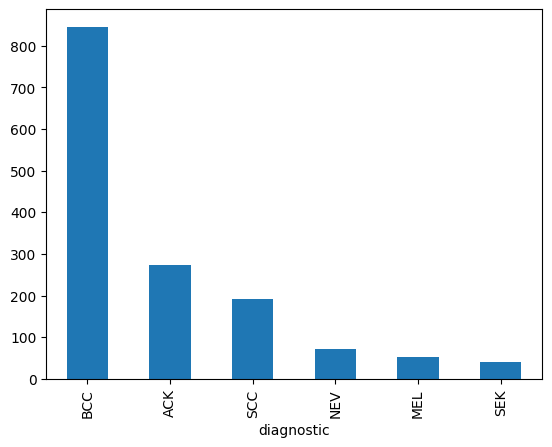

In [100]:
# Visualize the count of each class
df["diagnostic"].value_counts().plot(kind="bar")

In [101]:
df.info

<bound method DataFrame.info of      patient_id  lesion_id  smoke  drink background_father background_mother  \
1        PAT_46        881  False  False         POMERANIA         POMERANIA   
4       PAT_684       1302  False   True         POMERANIA         POMERANIA   
6       PAT_778       1471  False   True           GERMANY             ITALY   
7       PAT_117        179  False  False         POMERANIA         POMERANIA   
9       PAT_705       4015  False   True           GERMANY           GERMANY   
...         ...        ...    ...    ...               ...               ...   
2289    PAT_386        785   True  False         POMERANIA         POMERANIA   
2291    PAT_273        421  False  False         POMERANIA         POMERANIA   
2292    PAT_491        934  False  False         POMERANIA         POMERANIA   
2294     PAT_46        880  False  False         POMERANIA         POMERANIA   
2296    PAT_326        690  False  False         POMERANIA         POMERANIA   

      a

In [102]:
df.describe

<bound method NDFrame.describe of      patient_id  lesion_id  smoke  drink background_father background_mother  \
1        PAT_46        881  False  False         POMERANIA         POMERANIA   
4       PAT_684       1302  False   True         POMERANIA         POMERANIA   
6       PAT_778       1471  False   True           GERMANY             ITALY   
7       PAT_117        179  False  False         POMERANIA         POMERANIA   
9       PAT_705       4015  False   True           GERMANY           GERMANY   
...         ...        ...    ...    ...               ...               ...   
2289    PAT_386        785   True  False         POMERANIA         POMERANIA   
2291    PAT_273        421  False  False         POMERANIA         POMERANIA   
2292    PAT_491        934  False  False         POMERANIA         POMERANIA   
2294     PAT_46        880  False  False         POMERANIA         POMERANIA   
2296    PAT_326        690  False  False         POMERANIA         POMERANIA   

     

In [103]:
import seaborn as sns

(5.5, -0.5)

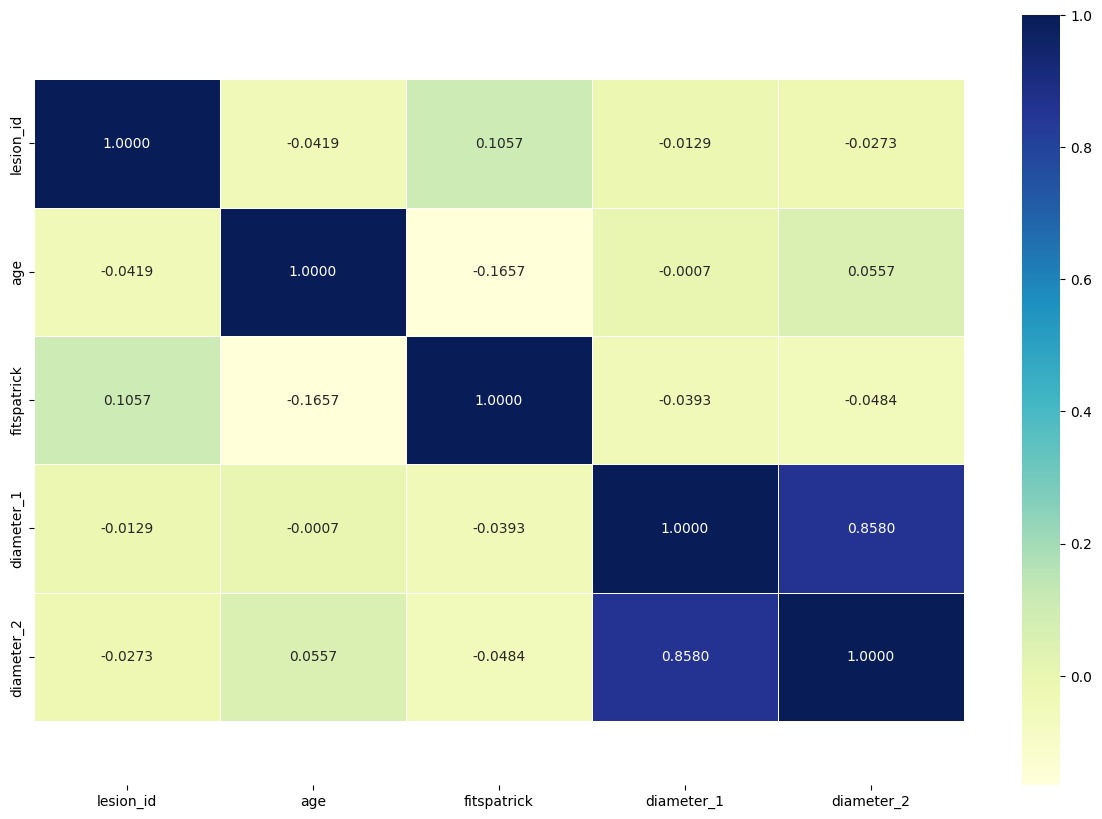

In [104]:
corr_matrix = df.select_dtypes(include = np.number).corr()
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths = 0.5,
                 fmt = ".4f",
                 cmap = "YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

### Load the tabular and image data and learners

In [105]:
# Get validation data indexes
def get_val_idxs(n, seed=42):
    np.random.seed(seed)
    return np.random.permutation(np.arange(n))[0:int(0.2 * n)]

In [106]:
val_idxs = get_val_idxs(len(df))

In [107]:
# Preprocessing
procs = [Categorify, Normalize]

In [108]:
import sklearn.utils

In [109]:
# Set up tabular data
tab_data = TabularDataLoaders.from_df(df, path="", y_names=dep_var, cat_names=cat_names, cont_names=cont_names, procs=procs, bs=32, valid_idx=val_idxs, shuffle = False)

In [110]:
# Calculate class weights
class_weights = sklearn.utils.class_weight.compute_class_weight("balanced", classes=np.unique(tab_data.train_ds.y), 
                                     y=tab_data.train_ds.y)

In [111]:
# Set up tabular learner
tab_learn = tabular_learner(tab_data, loss_func=CrossEntropyLossFlat(weight=torch.tensor(class_weights, dtype=torch.float32)))

## 1. ResNet50 on image data

In [112]:
# Set up image data
img_data = (ImageDataLoaders.from_df(df=df,
                                folder="../input/pad-ufes-20/PAD-UFES-20/Dataset/",
                                fn_col="img_id",
                                label_col="diagnostic",
                                bs=32,
                                item_tfms=Resize(224),
                                batch_tfms=tfms,
                                splitter=IndexSplitter(valid_idx=val_idxs),
                                shuffle = False)
)

In [113]:
# Calculate class weights
img_class_weights = sklearn.utils.class_weight.compute_class_weight("balanced", classes=np.unique(img_data.train_ds.vocab), 
                                     y=img_data.train_ds.vocab)


In [114]:
# Set up image learner
img_learn = vision_learner(img_data, resnet50,
                    pretrained=True,
                    loss_func=CrossEntropyLossFlat(weight=torch.tensor(img_class_weights, dtype=torch.float32)),
                    metrics=[accuracy, F1Score(average="macro")])

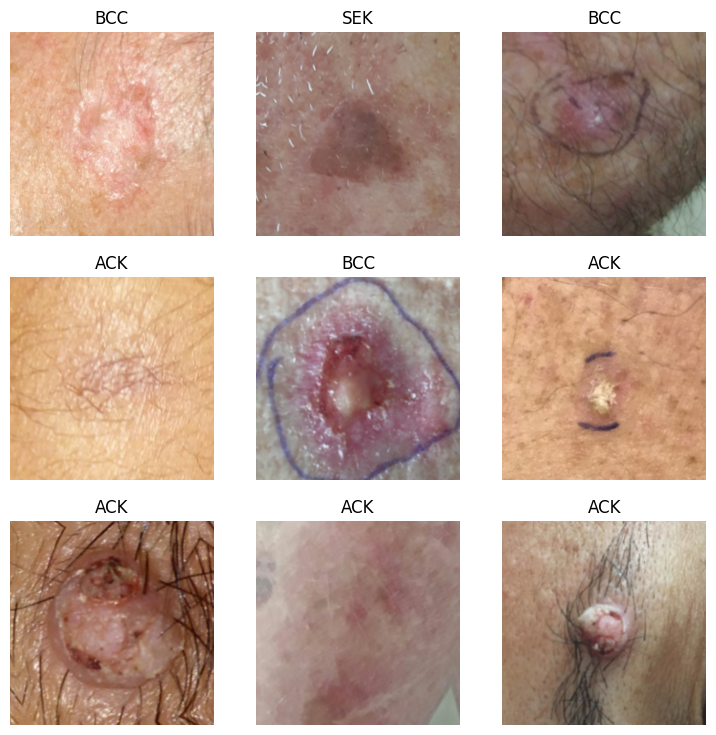

In [115]:
img_data.train.show_batch()

In [116]:
img_learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [117]:
img_learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

SuggestedLRs(valley=0.005248074419796467)

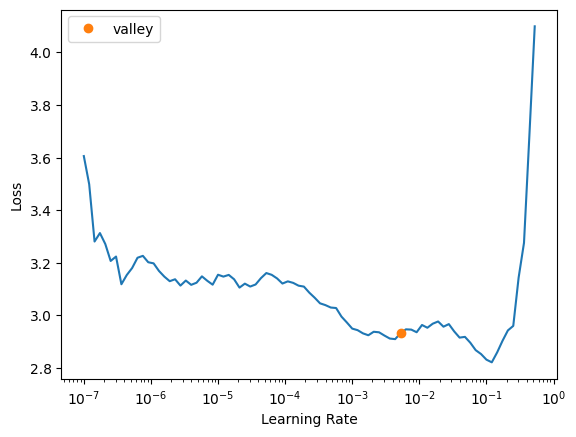

In [118]:
img_learn.lr_find()

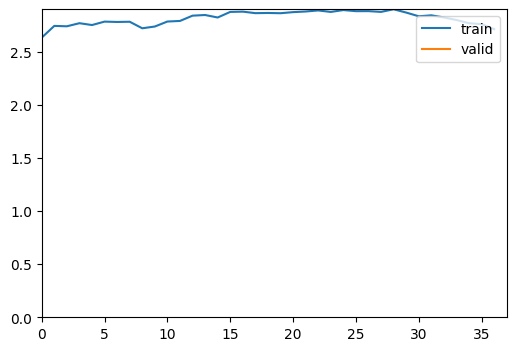

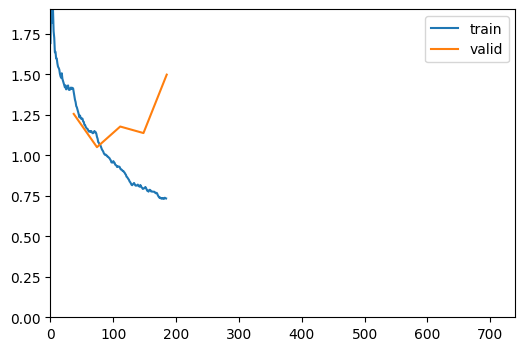

In [ ]:
# Fine-tune the CNN on PAD-UFES-20 dataset
img_learn.fine_tune(20, base_lr = 1e-2, cbs = [ShowGraphCallback(), SaveModelCallback(every_epoch=True, with_opt=True)])

In [28]:
img_learn.load("./model_16")

#### Model evaluation

In [29]:
img_learn.predict(f"./images/PAT_1516_1765_530.png")

('NEV',
 tensor(3),
 tensor([4.9000e-05, 3.3609e-09, 2.2274e-02, 9.6136e-01, 2.7977e-05, 1.6285e-02]))

In [30]:
tta = img_learn.tta(use_max=True)

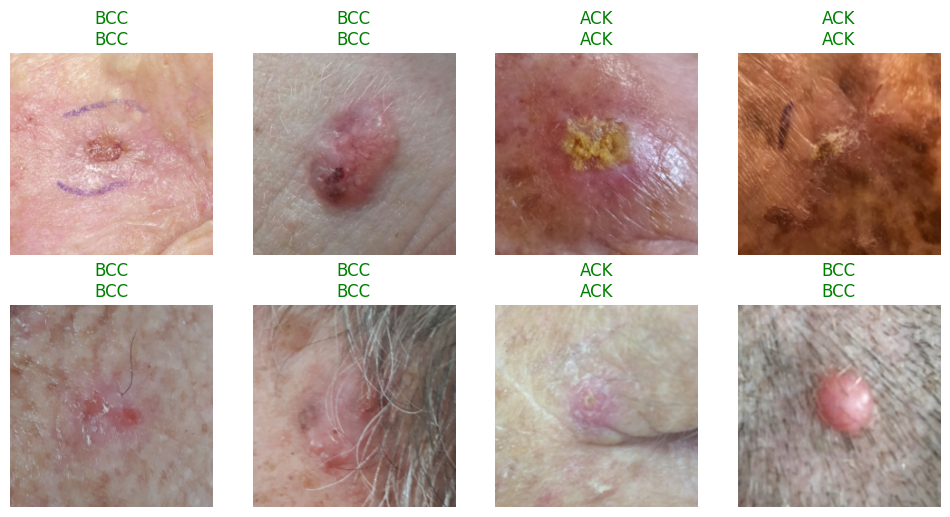

In [31]:
img_learn.show_results(max_n=8)

In [32]:
interp = Interpretation.from_learner(img_learn)

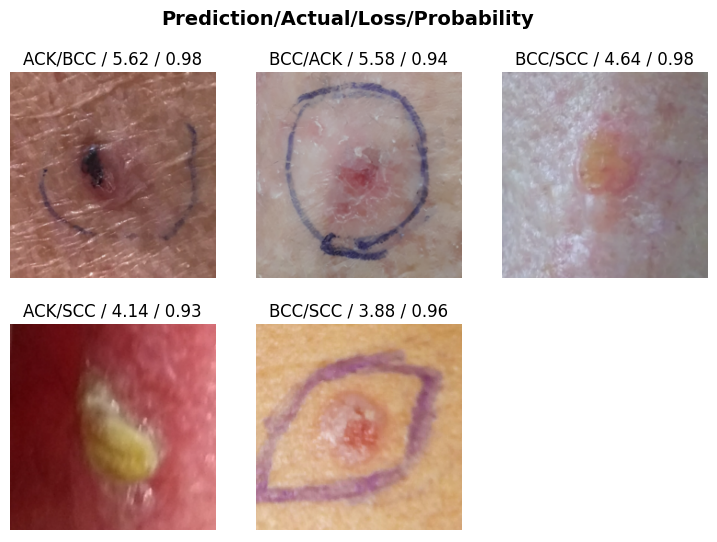

In [33]:
interp.plot_top_losses(5)

In [34]:
c_interp = ClassificationInterpretation.from_learner(img_learn)

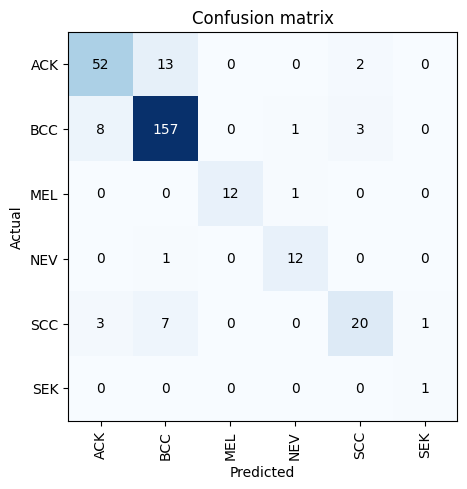

In [35]:
c_interp.plot_confusion_matrix()

In [36]:
preds = img_learn.get_preds()
pred_class = preds[0].max(1).indices
tgts = preds[1]

In [37]:
for i, name in enumerate(img_data.train.vocab):
    idx = torch.nonzero(tgts==i)
    subset = (tgts == pred_class)[idx]
    acc = subset.squeeze().float().mean()
    print(f'{name}: {acc:.1%}')

ACK: 77.6%

BCC: 92.9%

MEL: 92.3%

NEV: 92.3%

SCC: 64.5%

SEK: 100.0%


In [38]:
validation_metrics = img_learn.validate()

In [39]:
acc = validation_metrics[1]
f1_score = validation_metrics[2]

acc, f1_score

(0.8639456033706665, 0.8224567342146593)

#### Visualize the kernels of the first convolution layer

In [40]:
import matplotlib.pyplot as plt

In [41]:
# Extract the weights of the first convolutional layer
first_layer_weights = img_learn.model[0][0].weight

In [42]:
first_layer_weights = img_learn.model[0][0].weight.detach().cpu().numpy()

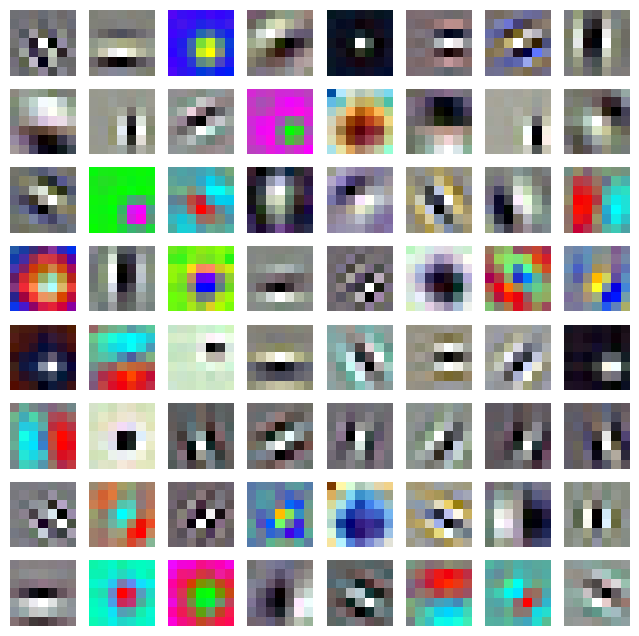

In [43]:
# Visualize the kernels
fig, axarr = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axarr.flat):
    I = first_layer_weights[i, :, :, :]
    I = I.transpose(1, 2, 0)
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)
    I = (I - I_min)/(I_max-I_min)
    ax.imshow(I)
    ax.axis("off")
    
plt.show()

#### Visualize using GradCAM

In [66]:
from pytorch_grad_cam import GradCAM, EigenCAM, HiResCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from PIL import Image

In [93]:
model = img_learn.model
model.eval()

model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [152]:
img = np.array(Image.open("./images/PAT_1516_1765_530.png"))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [162]:
# Define target_layers and targets
target_layers = [model[0][-1]]
targets = None

target_layers

[Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): Bottleneck(
     (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

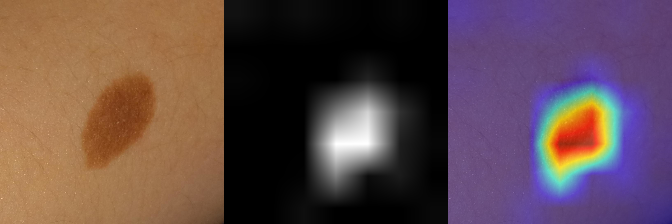

In [163]:
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

#### Visualize using EigenCAM

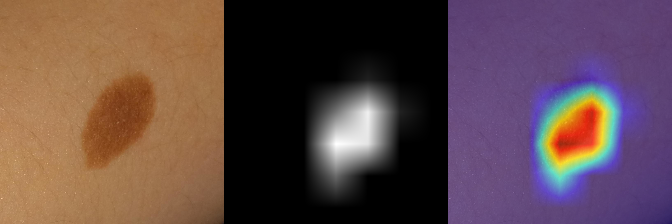

In [164]:
with EigenCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

#### Visualize using HiResCAM

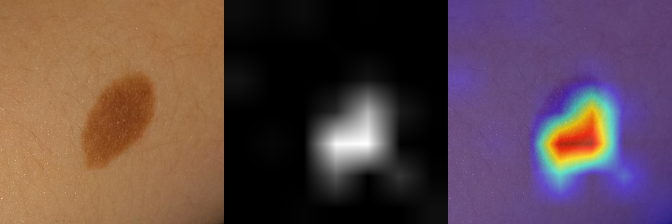

In [165]:
with HiResCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam, cam_image))
Image.fromarray(images)

### Feature Extraction

In [166]:
# Extract features from pre-trained CNN
hook_out = hook_output(img_learn.model[0][-1], cpu = True)

In [167]:
# Get feature vector from CNN
def get_features(x):
    f = img_learn.model.eval()(x)
    return hook_out.stored.numpy()

In [168]:
# Get features from images
def get_image_features(dl):
    features = []
    for xb, yb in dl:
        features.append(get_features(xb))
    return np.concatenate(features)

In [169]:
# Get features from images for train and test sets
train_image_features = get_image_features(img_data.train)
test_image_features = get_image_features(img_data.valid)

In [170]:
train_image_features.shape

(1180, 2048, 7, 7)

In [171]:
# Flatten the image features
train_image_features_flat = train_image_features.reshape(train_image_features.shape[0], -1)
test_image_features_flat = test_image_features.reshape(test_image_features.shape[0], -1)

In [172]:
train_image_features_flat.shape

(1180, 100352)

In [173]:
# Remove the hook
hook_out.remove()

### Fuse tabular data and image features

In [180]:
from sklearn.preprocessing import StandardScaler

In [181]:
X_train = tab_data.train_ds.xs
X_test = tab_data.valid_ds.xs
y_train = tab_data.train_ds.ys
y_test = tab_data.valid_ds.ys

In [182]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [183]:
X_train_scaled.shape, train_image_features_flat.shape

((1180, 21), (1180, 100352))

In [184]:
X_train_scaled.shape

(1180, 21)

In [185]:
# Fuse features from clinical attributes and images
X_train_fused = np.concatenate((X_train_scaled, train_image_features_flat), axis=1)
X_test_fused = np.concatenate((X_test_scaled, test_image_features_flat), axis=1)

In [186]:
X_train_fused.shape

(1180, 100373)

### Logistic Regression

In [187]:
from sklearn.linear_model import LogisticRegression

In [188]:
np.random.seed(42)

LR = LogisticRegression(random_state=42, class_weight= "balanced", max_iter = 5000)

In [189]:
LR.fit(X_train_fused, y_train.values.ravel())

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

In [190]:
from sklearn.metrics import *

In [191]:
# Validate the model
y_test_pred_LR = LR.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_LR))

Test Accuracy: 0.5476190476190477


In [192]:
# Evaluate the model
accuracy_LR = accuracy_score(y_test, y_test_pred_LR)
conf_matrix_LR = confusion_matrix(y_test, y_test_pred_LR, labels=LR.classes_)
class_report_LR = classification_report(y_test, y_test_pred_LR)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_LR)
print("\nConfusion Matrix:\n", conf_matrix_LR)
print("\nClassification Report:\n", class_report_LR)

Accuracy of the Logistic Regression model: 0.5476190476190477



Confusion Matrix:

 [[  1  51   0   0   0   0]

 [  4 159   0   0   2   0]

 [  0   9   0   0   0   0]

 [  0  22   0   0   0   0]

 [  1  36   0   0   1   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.17      0.02      0.03        52

           1       0.56      0.96      0.71       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.33      0.03      0.05        38

           5       0.00      0.00      0.00         8



    accuracy                           0.55       294

   macro avg       0.18      0.17      0.13       294

weighted avg       0.39      0.55      0.41       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [193]:
from sklearn.model_selection import RandomizedSearchCV

In [194]:
# Define parameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear", "newton-cg"],
                "penalty": [None, "l1", "l2"]}

In [195]:
# Define grid search
np.random.seed(42)

grid_search = RandomizedSearchCV(estimator = LR, param_distributions=log_reg_grid, n_iter = 20, cv=5)

In [196]:
grid_result = grid_search.fit(X_train_fused, y_train.values.ravel())

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/

In [197]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.572881 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.08858667904100823}


#### Model Evaluation

In [198]:
np.random.seed(42)

bestLR = LogisticRegression(random_state=42, class_weight = "balanced", penalty="l1", solver="liblinear", C = 0.08858667904100823)

In [199]:
bestLR.fit(X_train_fused, y_train.values.ravel())

LogisticRegression(C=0.08858667904100823, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [200]:
# Validate the model
y_test_pred_bestLR = bestLR.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_bestLR))

Test Accuracy: 0.5408163265306123


In [201]:
# Evaluate the model
accuracy_bestLR = accuracy_score(y_test, y_test_pred_bestLR)
conf_matrix_bestLR = confusion_matrix(y_test, y_test_pred_bestLR, labels=bestLR.classes_)
class_report_bestLR = classification_report(y_test, y_test_pred_bestLR)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_bestLR)
print("\nConfusion Matrix:\n", conf_matrix_bestLR)
print("\nClassification Report:\n", class_report_bestLR)

Accuracy of the Logistic Regression model: 0.5408163265306123



Confusion Matrix:

 [[ 24  21   0   0   6   1]

 [ 23 125   1   3  10   3]

 [  4   4   0   0   1   0]

 [  3  10   0   5   4   0]

 [  9  23   0   1   5   0]

 [  0   6   0   0   2   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.38      0.46      0.42        52

           1       0.66      0.76      0.71       165

           2       0.00      0.00      0.00         9

           3       0.56      0.23      0.32        22

           4       0.18      0.13      0.15        38

           5       0.00      0.00      0.00         8



    accuracy                           0.54       294

   macro avg       0.30      0.26      0.27       294

weighted avg       0.50      0.54      0.51       294




### Random Forest

In [202]:
from sklearn.ensemble import RandomForestClassifier

In [203]:
np.random.seed(42)

RFC = RandomForestClassifier(n_estimators=20, class_weight="balanced", max_depth=20, random_state=42)

In [204]:
RFC.fit(X_train_fused, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=20,
                       random_state=42)

In [206]:
# Validate the model
y_test_pred_RFC = RFC.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_RFC))

Test Accuracy: 0.5714285714285714


In [207]:
# Evaluate the model
accuracy_RFC = accuracy_score(y_test, y_test_pred_RFC)
conf_matrix_RFC = confusion_matrix(y_test, y_test_pred_RFC, labels=RFC.classes_)
class_report_RFC = classification_report(y_test, y_test_pred_RFC)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_RFC)
print("\nConfusion Matrix:\n", conf_matrix_RFC)
print("\nClassification Report:\n", class_report_RFC)

Accuracy of the Random Forest model: 0.5714285714285714



Confusion Matrix:

 [[ 14  35   0   0   3   0]

 [  6 151   0   0   8   0]

 [  2   6   0   0   1   0]

 [  2  19   0   0   1   0]

 [  3  32   0   0   3   0]

 [  2   5   0   0   1   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.48      0.27      0.35        52

           1       0.61      0.92      0.73       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.18      0.08      0.11        38

           5       0.00      0.00      0.00         8



    accuracy                           0.57       294

   macro avg       0.21      0.21      0.20       294

weighted avg       0.45      0.57      0.49       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [208]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [209]:
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RFC,  
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

In [210]:
np.random.seed(42)

rs_rf_best = rs_rf.fit(X_train_fused, y_train.values.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [211]:
rs_rf_best.best_params_

{'n_estimators': 910,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 10}

#### Model Evaluation

In [212]:
np.random.seed(42)

RFCbest = RandomForestClassifier(max_depth=18, class_weight="balanced", n_estimators=910, random_state=42, min_samples_split = 18, min_samples_leaf = 1)

In [213]:
RFCbest.fit(X_train_fused, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=18,
                       min_samples_split=18, n_estimators=910, random_state=42)

In [214]:
# Validate the model
y_test_pred_RFCbest = RFCbest.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_RFCbest))

Test Accuracy: 0.5986394557823129


In [215]:
# Evaluate the model
accuracy_RFCbest = accuracy_score(y_test, y_test_pred_RFCbest)
conf_matrix_RFCbest = confusion_matrix(y_test, y_test_pred_RFCbest, labels=RFCbest.classes_)
class_report_RFCbest = classification_report(y_test, y_test_pred_RFCbest)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_RFCbest)
print("\nConfusion Matrix:\n", conf_matrix_RFCbest)
print("\nClassification Report:\n", class_report_RFCbest)

Accuracy of the Random Forest model: 0.5986394557823129



Confusion Matrix:

 [[ 16  36   0   0   0   0]

 [  5 160   0   0   0   0]

 [  0   9   0   0   0   0]

 [  5  17   0   0   0   0]

 [  1  37   0   0   0   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.59      0.31      0.41        52

           1       0.60      0.97      0.74       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.60       294

   macro avg       0.20      0.21      0.19       294

weighted avg       0.44      0.60      0.49       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

### KNN

In [216]:
from sklearn.neighbors import KNeighborsClassifier

In [217]:
knc = KNeighborsClassifier(n_neighbors=5)

In [218]:
knc.fit(X_train_fused, y_train.values.ravel())

KNeighborsClassifier()

In [219]:
# Validate the model
y_test_pred_knc = knc.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_knc))

Test Accuracy: 0.5272108843537415


In [299]:
# Evaluate the model
accuracy_knc = accuracy_score(y_test, y_test_pred_knc)
conf_matrix_knc = confusion_matrix(y_test, y_test_pred_knc, labels=knc.classes_)
class_report_knc = classification_report(y_test, y_test_pred_knc)

# Print the evaluation results
print("Accuracy of the KNN model:", accuracy_knc)
print("\nConfusion Matrix:\n", conf_matrix_knc)
print("\nClassification Report:\n", class_report_knc)

Accuracy of the KNN model: 0.5272108843537415



Confusion Matrix:

 [[  0  48   0   0   4   0]

 [  0 152   0   0  13   0]

 [  0   9   0   0   0   0]

 [  0  18   0   0   4   0]

 [  0  35   0   0   3   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.00      0.00      0.00        52

           1       0.56      0.92      0.70       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.12      0.08      0.10        38

           5       0.00      0.00      0.00         8



    accuracy                           0.53       294

   macro avg       0.11      0.17      0.13       294

weighted avg       0.33      0.53      0.40       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [221]:
# Create an array of possible n_neighbors
n_neighbors_list = np.arange(1, 21, 1)

n_neighbors_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [222]:
# Train a KNeighborsClassifier with n_neighbors in n_neighbors_list
acc_train_list=[]

for i in n_neighbors_list:
  clf = KNeighborsClassifier(n_neighbors=i)
  clf.fit(X_train_fused, y_train.values.ravel())

  Y_train_pred = clf.predict(X_train_fused)
  confusion_train = confusion_matrix(y_train, Y_train_pred)
  acc_train = accuracy_score(y_train, Y_train_pred)
  acc_train_list.append(acc_train)

In [223]:
for i in range(0, len(n_neighbors_list)):
  print(f"n_neighbor {n_neighbors_list[i]}| training accuracy: {acc_train_list[i]}")

n_neighbor 1| training accuracy: 1.0

n_neighbor 2| training accuracy: 0.7889830508474577

n_neighbor 3| training accuracy: 0.8635593220338983

n_neighbor 4| training accuracy: 0.8008474576271186

n_neighbor 5| training accuracy: 0.7110169491525423

n_neighbor 6| training accuracy: 0.6830508474576271

n_neighbor 7| training accuracy: 0.6296610169491526

n_neighbor 8| training accuracy: 0.635593220338983

n_neighbor 9| training accuracy: 0.6008474576271187

n_neighbor 10| training accuracy: 0.5838983050847457

n_neighbor 11| training accuracy: 0.5771186440677966

n_neighbor 12| training accuracy: 0.576271186440678

n_neighbor 13| training accuracy: 0.576271186440678

n_neighbor 14| training accuracy: 0.576271186440678

n_neighbor 15| training accuracy: 0.576271186440678

n_neighbor 16| training accuracy: 0.576271186440678

n_neighbor 17| training accuracy: 0.576271186440678

n_neighbor 18| training accuracy: 0.576271186440678

n_neighbor 19| training accuracy: 0.576271186440678

n_neigh

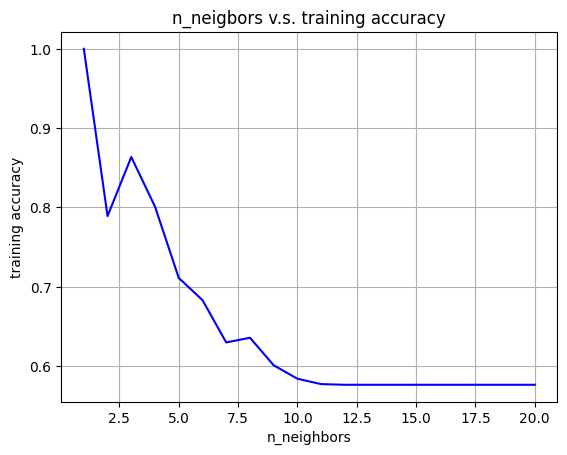

In [224]:
# Plot max_depth vs acc_train using max_depth_list and acc_train_list
plt.plot(n_neighbors_list, acc_train_list, "b")
plt.xlabel("n_neighbors")
plt.ylabel("training accuracy")
plt.title("n_neigbors v.s. training accuracy")
plt.grid(True)

In [225]:
# Find the best n_neighbors
n_neighbors_best = n_neighbors_list[np.argmax(acc_train_list)]

n_neighbors_best

1

#### Model Evaluation

In [233]:
kncbest = KNeighborsClassifier(n_neighbors=n_neighbors_best)

In [234]:
kncbest.fit(X_train_fused, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=1)

In [235]:
# Validate the model
y_test_pred_kncbest = kncbest.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_kncbest))

Test Accuracy: 0.5204081632653061


In [300]:
# Evaluate the model
accuracy_kncbest = accuracy_score(y_test, y_test_pred_kncbest)
conf_matrix_kncbest = confusion_matrix(y_test, y_test_pred_kncbest, labels=kncbest.classes_)
class_report_kncbest = classification_report(y_test, y_test_pred_kncbest)

# Print the evaluation results
print("Accuracy of the KNN model:", accuracy_kncbest)
print("\nConfusion Matrix:\n", conf_matrix_kncbest)
print("\nClassification Report:\n", class_report_kncbest)

Accuracy of the KNN model: 0.5204081632653061



Confusion Matrix:

 [[  0  47   0   1   4   0]

 [  1 147   0   3  14   0]

 [  0   8   0   1   0   0]

 [  0  21   0   1   0   0]

 [  0  32   0   1   5   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.00      0.00      0.00        52

           1       0.56      0.89      0.69       165

           2       0.00      0.00      0.00         9

           3       0.14      0.05      0.07        22

           4       0.22      0.13      0.16        38

           5       0.00      0.00      0.00         8



    accuracy                           0.52       294

   macro avg       0.15      0.18      0.15       294

weighted avg       0.35      0.52      0.41       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

### XGBoost

In [237]:
import xgboost

In [238]:
xgb = xgboost.XGBClassifier(objective="multi:softprob", random_state = 42)

In [239]:
xgb.fit(X_train_fused, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [240]:
y_test_pred_xgb = xgb.predict(X_test_fused)

In [258]:
# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)
class_report_xgb = classification_report(y_test, y_test_pred_xgb)

# Print the evaluation results
print("Accuracy of the XGB model:", accuracy_xgb)
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", class_report_xgb)

Accuracy of the XGB model: 0.6496598639455783



Confusion Matrix:

 [[ 26  26   0   0   0   0]

 [ 10 154   0   0   1   0]

 [  1   5   1   1   1   0]

 [  1  12   0   9   0   0]

 [  5  32   0   0   1   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.60      0.50      0.55        52

           1       0.65      0.93      0.77       165

           2       1.00      0.11      0.20         9

           3       0.90      0.41      0.56        22

           4       0.33      0.03      0.05        38

           5       0.00      0.00      0.00         8



    accuracy                           0.65       294

   macro avg       0.58      0.33      0.35       294

weighted avg       0.61      0.65      0.58       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [243]:
from scipy.stats import uniform, randint

In [244]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5), 
    "learning_rate": uniform(0, 0.5),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

In [245]:
search = RandomizedSearchCV(xgb, param_distributions = params, random_state = 42, n_iter = 5, cv = 3, verbose = 1, n_jobs = 1, return_train_score = True)

In [246]:
search.fit(X_train_fused, y_train.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x175460820>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2cb98b970>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a78848e0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2a8699900>},
                   random_state=42, return_train_score=True, verbose=1)

In [242]:
def report_best_scores(results, n_top = 3):
    for i in range(1, n_top +1):
        rank = np.flatnonzero(results["rank_test_score"] == i)
        for x in rank:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results['mean_test_score'][x]} (std: {results['std_test_score'][x]})")
            print(f"Parameters: {results['params'][x]}")
            print("")

In [247]:
report_best_scores(search.cv_results_, 1)

Model with rank: 1

Mean validation score: 0.6661112618023534 (std: 0.008248415201217042)

Parameters: {'colsample_bytree': 0.8835558684167137, 'gamma': 0.06974693032602092, 'learning_rate': 0.14607232426760908, 'max_depth': 5, 'n_estimators': 114, 'subsample': 0.7824279936868144}




#### Model Evaluation

In [248]:
xgb_best = xgboost.XGBClassifier(objective="multi:softprob", random_state = 42, colsample_bytree = 0.8835558684167137, gamma = 0.06974693032602092, learning_rate=0.14607232426760908, max_depth = 5, n_estimators = 114, subsample = 0.7824279936868144)

In [249]:
xgb_best.fit(X_train_fused, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8835558684167137, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.06974693032602092,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14607232426760908,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=114, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [250]:
y_test_pred_xgb_best = xgb_best.predict(X_test_fused)

In [256]:
# Evaluate the model
accuracy_xgb_best = accuracy_score(y_test, y_test_pred_xgb_best)
conf_matrix_xgb_best = confusion_matrix(y_test, y_test_pred_xgb_best)
class_report_xgb_best = classification_report(y_test, y_test_pred_xgb_best)

# Print the evaluation results
print("Accuracy of the tuned XGB model:", accuracy_xgb_best)
print("\nConfusion Matrix:\n", conf_matrix_xgb_best)
print("\nClassification Report:\n", class_report_xgb_best)

Accuracy of the tuned XGB model: 0.6462585034013606



Confusion Matrix:

 [[ 24  27   0   0   1   0]

 [  6 157   0   0   2   0]

 [  1   6   1   1   0   0]

 [  1  14   0   7   0   0]

 [  4  33   0   0   1   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.67      0.46      0.55        52

           1       0.64      0.95      0.77       165

           2       1.00      0.11      0.20         9

           3       0.88      0.32      0.47        22

           4       0.25      0.03      0.05        38

           5       0.00      0.00      0.00         8



    accuracy                           0.65       294

   macro avg       0.57      0.31      0.34       294

weighted avg       0.61      0.65      0.57       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

## 2. ResNet18 on image data

In [257]:
# Calculate class weights
img_class_weights = sklearn.utils.class_weight.compute_class_weight("balanced", classes=np.unique(img_data.train_ds.vocab), 
                                     y=img_data.train_ds.vocab)

In [259]:
# Set up image learner
img_learn_resnet18 = vision_learner(img_data, resnet18,
                    pretrained=True,
                    loss_func=CrossEntropyLossFlat(weight=torch.tensor(img_class_weights, dtype=torch.float32)),
                    metrics=[accuracy, F1Score(average="macro")])

In [260]:
img_learn_resnet18.loss_func

FlattenedLoss of CrossEntropyLoss()

In [261]:
img_learn_resnet18.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

SuggestedLRs(valley=0.0030199517495930195)

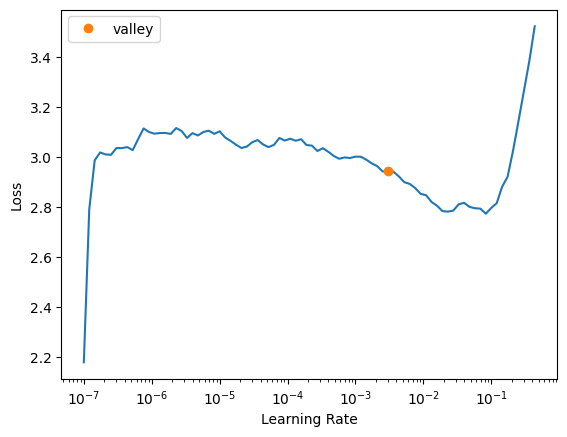

In [263]:
img_learn_resnet18.lr_find()

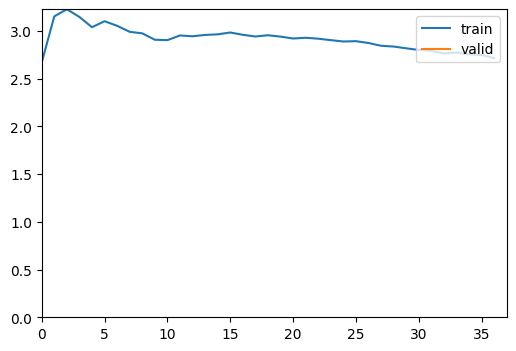

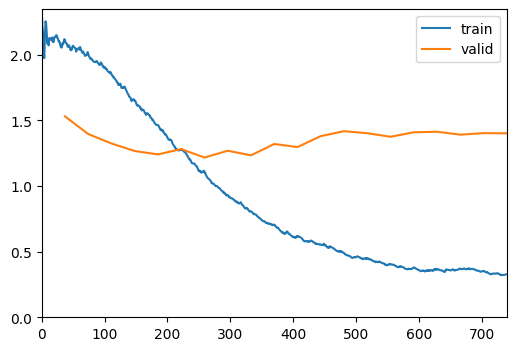

In [264]:
# Fine-tune the CNN on PAD-UFES-20 dataset
img_learn_resnet18.fine_tune(20, base_lr = 1e-3, cbs = [ShowGraphCallback(), SaveModelCallback(every_epoch=True, with_opt=True, fname="resnet18")])

In [262]:
img_learn_resnet18.load("./resnet18_18")

#### Model evaluation

In [263]:
img_learn_resnet18.predict(f"./images/PAT_1516_1765_530.png")

('NEV',
 tensor(3),
 tensor([2.6927e-07, 7.1890e-18, 7.7204e-04, 9.8814e-01, 3.0864e-08, 1.1086e-02]))

In [264]:
tta_resnet18 = img_learn_resnet18.tta(use_max=True)

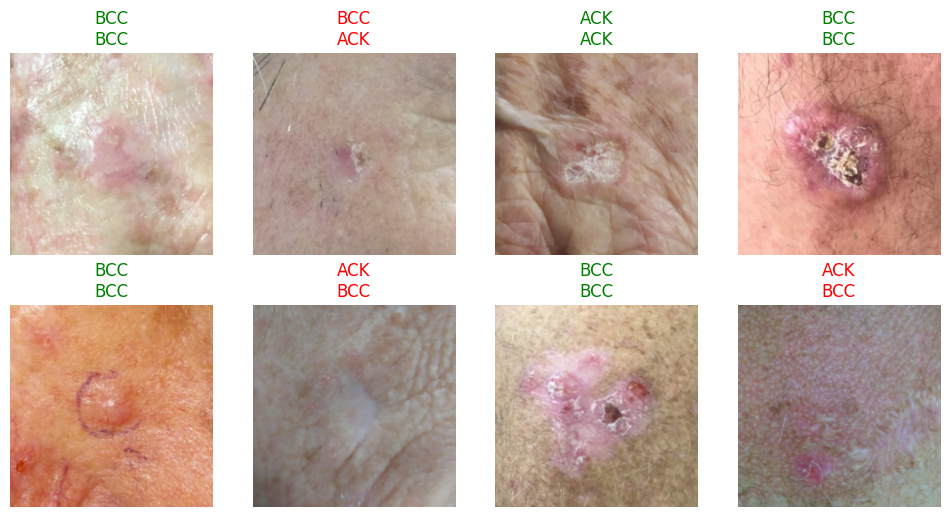

In [268]:
img_learn_resnet18.show_results(max_n=8)

In [269]:
interp_resnet18 = Interpretation.from_learner(img_learn_resnet18)

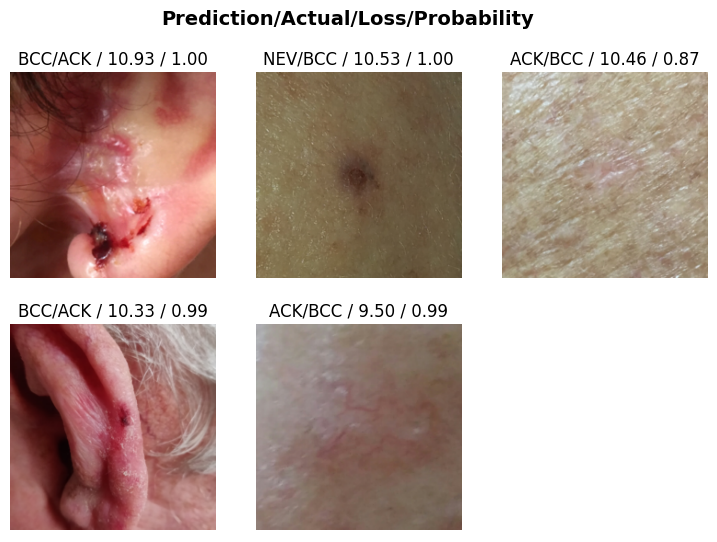

In [270]:
interp_resnet18.plot_top_losses(5)

In [271]:
c_interp_resnet18 = ClassificationInterpretation.from_learner(img_learn_resnet18)

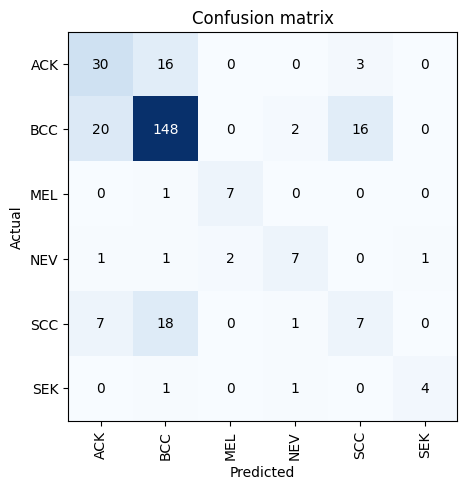

In [272]:
c_interp_resnet18.plot_confusion_matrix()

In [273]:
preds = img_learn_resnet18.get_preds()
pred_class = preds[0].max(1).indices
tgts = preds[1]

In [274]:
for i, name in enumerate(img_data.train.vocab):
    idx = torch.nonzero(tgts==i)
    subset = (tgts == pred_class)[idx]
    acc = subset.squeeze().float().mean()
    print(f'{name}: {acc:.1%}')

ACK: 61.2%

BCC: 79.6%

MEL: 87.5%

NEV: 58.3%

SCC: 21.2%

SEK: 66.7%


In [275]:
validation_metrics = img_learn_resnet18.validate()

In [276]:
acc = validation_metrics[1]
f1_score = validation_metrics[2]

acc, f1_score

(0.6904761791229248, 0.625896209354027)

#### Visualize the kernels of the first convolution layer

In [265]:
# Extract the weights of the first convolutional layer
first_layer_weights = img_learn_resnet18.model[0][0].weight.detach().cpu().numpy()

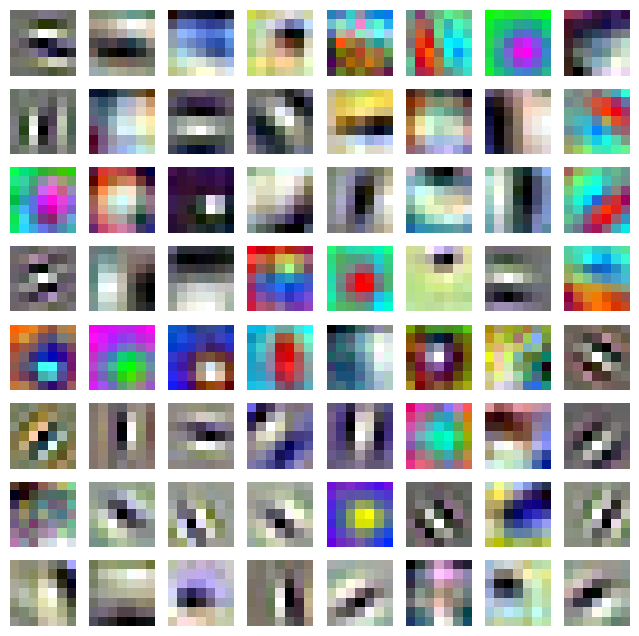

In [266]:
# Visualize the kernels
fig, axarr = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axarr.flat):
    I = first_layer_weights[i, :, :, :]
    I = I.transpose(1, 2, 0)
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)
    I = (I - I_min)/(I_max-I_min)
    ax.imshow(I)
    ax.axis("off")
    
plt.show()

#### Visualize using GradCAM

In [267]:
model = img_learn_resnet18.model
model.eval()

model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [268]:
img = np.array(Image.open("./images/PAT_1516_1765_530.png"))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [269]:
# Define target_layers and targets
target_layers = [model[0][-1]]
targets = None

target_layers

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

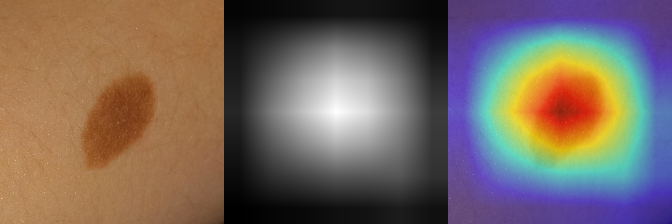

In [274]:
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

#### Visualize using EigenCAM

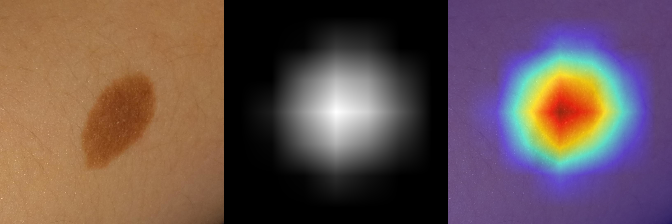

In [272]:
with EigenCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

#### Visualize using HiResCAM

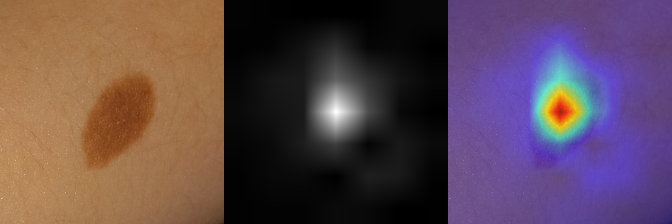

In [273]:
with HiResCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam, cam_image))
Image.fromarray(images)

### Feature Extraction

In [275]:
# Extract features from pre-trained CNN
hook_out = hook_output(img_learn_resnet18.model[0][-1], cpu = True)

In [276]:
# Get feature vector from CNN
def get_features(x):
    f = img_learn_resnet18.model.eval()(x)
    return hook_out.stored.numpy()

In [278]:
# Get features from images for train and test sets
train_image_features = get_image_features(img_data.train)
test_image_features = get_image_features(img_data.valid)

In [279]:
train_image_features.shape

(1180, 512, 7, 7)

In [280]:
# Flatten the image features
train_image_features_flat = train_image_features.reshape(train_image_features.shape[0], -1)
test_image_features_flat = test_image_features.reshape(test_image_features.shape[0], -1)

In [281]:
train_image_features_flat.shape

(1180, 25088)

In [282]:
# Remove the hook
hook_out.remove()

### Fuse tabular data and image features

In [283]:
X_train = tab_data.train_ds.xs
X_test = tab_data.valid_ds.xs
y_train = tab_data.train_ds.ys
y_test = tab_data.valid_ds.ys

In [284]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [285]:
X_train_scaled.shape, train_image_features_flat.shape

((1180, 21), (1180, 25088))

In [286]:
X_train_scaled.shape

(1180, 21)

In [287]:
# Fuse features from clinical attributes and images
X_train_fused = np.concatenate((X_train_scaled, train_image_features_flat), axis=1)
X_test_fused = np.concatenate((X_test_scaled, test_image_features_flat), axis=1)

In [288]:
X_train_fused.shape

(1180, 25109)

### Logistic Regression

In [292]:
LR = LogisticRegression(random_state=42, class_weight= "balanced")

In [293]:
LR.fit(X_train_fused, y_train.values.ravel())

LogisticRegression(class_weight='balanced', random_state=42)

In [294]:
# Validate the model
y_test_pred_LR = LR.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_LR))

Test Accuracy: 0.41156462585034015


In [295]:
# Evaluate the model
accuracy_LR = accuracy_score(y_test, y_test_pred_LR)
conf_matrix_LR = confusion_matrix(y_test, y_test_pred_LR, labels=LR.classes_)
class_report_LR = classification_report(y_test, y_test_pred_LR)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_LR)
print("\nConfusion Matrix:\n", conf_matrix_LR)
print("\nClassification Report:\n", class_report_LR)

Accuracy of the Logistic Regression model: 0.41156462585034015



Confusion Matrix:

 [[  9  36   0   0   7   0]

 [ 27 108   3   3  23   1]

 [  2   6   0   0   1   0]

 [  5  12   0   2   3   0]

 [  5  29   1   1   2   0]

 [  0   6   1   1   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.19      0.17      0.18        52

           1       0.55      0.65      0.60       165

           2       0.00      0.00      0.00         9

           3       0.29      0.09      0.14        22

           4       0.06      0.05      0.05        38

           5       0.00      0.00      0.00         8



    accuracy                           0.41       294

   macro avg       0.18      0.16      0.16       294

weighted avg       0.37      0.41      0.38       294




#### Hyperparameter tuning

In [296]:
# Define parameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear", "newton-cg"],
                "penalty": [None, "l1", "l2"]}

In [297]:
# Define grid search
grid_search = RandomizedSearchCV(estimator = LR, param_distributions=log_reg_grid, n_iter = 20, cv=5)

In [298]:
grid_result = grid_search.fit(X_train_fused, y_train.values.ravel())

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/

In [301]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.572034 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 1.623776739188721}


#### Model Evaluation

In [302]:
bestLR = LogisticRegression(random_state=42, class_weight = "balanced", penalty="l1", solver="liblinear", C=1.623776739188721)

In [303]:
bestLR.fit(X_train_fused, y_train.values.ravel())

LogisticRegression(C=1.623776739188721, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [304]:
# Validate the model
y_test_pred_bestLR = bestLR.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_bestLR))

Test Accuracy: 0.5408163265306123


In [305]:
# Evaluate the model
accuracy_bestLR = accuracy_score(y_test, y_test_pred_bestLR)
conf_matrix_bestLR = confusion_matrix(y_test, y_test_pred_bestLR, labels=bestLR.classes_)
class_report_bestLR = classification_report(y_test, y_test_pred_bestLR)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_bestLR)
print("\nConfusion Matrix:\n", conf_matrix_bestLR)
print("\nClassification Report:\n", class_report_bestLR)

Accuracy of the Logistic Regression model: 0.5408163265306123



Confusion Matrix:

 [[ 24  20   1   0   7   0]

 [ 14 124   2   0  24   1]

 [  2   4   1   1   1   0]

 [  4  13   0   2   3   0]

 [  7  23   0   0   8   0]

 [  1   4   0   1   2   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.46      0.46      0.46        52

           1       0.66      0.75      0.70       165

           2       0.25      0.11      0.15         9

           3       0.50      0.09      0.15        22

           4       0.18      0.21      0.19        38

           5       0.00      0.00      0.00         8



    accuracy                           0.54       294

   macro avg       0.34      0.27      0.28       294

weighted avg       0.52      0.54      0.52       294




### Random Forest

In [306]:
RFC = RandomForestClassifier(n_estimators=20, class_weight="balanced", max_depth=20, random_state=42)

In [307]:
RFC.fit(X_train_fused, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=20,
                       random_state=42)

In [308]:
# Validate the model
y_test_pred_RFC = RFC.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_RFC))

Test Accuracy: 0.5544217687074829


In [309]:
# Evaluate the model
accuracy_RFC = accuracy_score(y_test, y_test_pred_RFC)
conf_matrix_RFC = confusion_matrix(y_test, y_test_pred_RFC, labels=RFC.classes_)
class_report_RFC = classification_report(y_test, y_test_pred_RFC)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_RFC)
print("\nConfusion Matrix:\n", conf_matrix_RFC)
print("\nClassification Report:\n", class_report_RFC)

Accuracy of the Random Forest model: 0.5544217687074829



Confusion Matrix:

 [[  0  52   0   0   0   0]

 [  1 163   0   0   1   0]

 [  0   9   0   0   0   0]

 [  0  22   0   0   0   0]

 [  0  38   0   0   0   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.00      0.00      0.00        52

           1       0.56      0.99      0.71       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.55       294

   macro avg       0.09      0.16      0.12       294

weighted avg       0.31      0.55      0.40       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [310]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [311]:
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RFC,  
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

In [312]:
np.random.seed(42)

rs_rf_best = rs_rf.fit(X_train_fused, y_train.values.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [313]:
rs_rf_best.best_params_

{'n_estimators': 260,
 'min_samples_split': 16,
 'min_samples_leaf': 9,
 'max_depth': 10}

#### Model Evaluation

In [314]:
RFCbest = RandomForestClassifier(max_depth=10, class_weight="balanced", n_estimators=260, random_state=42, min_samples_split = 16, min_samples_leaf = 9)

In [315]:
RFCbest.fit(X_train_fused, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=9, min_samples_split=16,
                       n_estimators=260, random_state=42)

In [316]:
# Validate the model
y_test_pred_RFCbest = RFCbest.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_RFCbest))

Test Accuracy: 0.5680272108843537


In [317]:
# Evaluate the model
accuracy_RFCbest = accuracy_score(y_test, y_test_pred_RFCbest)
conf_matrix_RFCbest = confusion_matrix(y_test, y_test_pred_RFCbest, labels=RFCbest.classes_)
class_report_RFCbest = classification_report(y_test, y_test_pred_RFCbest)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_RFCbest)
print("\nConfusion Matrix:\n", conf_matrix_RFCbest)
print("\nClassification Report:\n", class_report_RFCbest)

Accuracy of the Random Forest model: 0.5680272108843537



Confusion Matrix:

 [[  3  49   0   0   0   0]

 [  1 164   0   0   0   0]

 [  0   9   0   0   0   0]

 [  1  21   0   0   0   0]

 [  0  38   0   0   0   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.60      0.06      0.11        52

           1       0.57      0.99      0.72       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.57       294

   macro avg       0.19      0.18      0.14       294

weighted avg       0.42      0.57      0.42       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

### KNN

In [318]:
knc = KNeighborsClassifier(n_neighbors=5)

In [319]:
knc.fit(X_train_fused, y_train.values.ravel())

KNeighborsClassifier()

In [320]:
# Validate the model
y_test_pred_knc = knc.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_knc))

Test Accuracy: 0.47619047619047616


In [418]:
# Evaluate the model
accuracy_knc = accuracy_score(y_test, y_test_pred_knc)
conf_matrix_knc = confusion_matrix(y_test, y_test_pred_knc, labels=knc.classes_)
class_report_knc = classification_report(y_test, y_test_pred_knc)

# Print the evaluation results
print("Accuracy of the KNN model:", accuracy_knc)
print("\nConfusion Matrix:\n", conf_matrix_knc)
print("\nClassification Report:\n", class_report_knc)

Accuracy of the KNN model: 0.47619047619047616



Confusion Matrix:

 [[  4  47   0   0   1   0]

 [ 26 134   0   2   3   0]

 [  1   8   0   0   0   0]

 [  2  18   0   0   2   0]

 [  7  29   0   0   2   0]

 [  1   7   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.10      0.08      0.09        52

           1       0.55      0.81      0.66       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.25      0.05      0.09        38

           5       0.00      0.00      0.00         8



    accuracy                           0.48       294

   macro avg       0.15      0.16      0.14       294

weighted avg       0.36      0.48      0.40       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [328]:
# Create an array of possible n_neighbors
n_neighbors_list = np.arange(1, 21, 1)

n_neighbors_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [329]:
# Train a KNeighborsClassifier with n_neighbors in n_neighbors_list
acc_train_list=[]

for i in n_neighbors_list:
  clf = KNeighborsClassifier(n_neighbors=i)
  clf.fit(X_train_fused, y_train.values.ravel())

  Y_train_pred = clf.predict(X_train_fused)
  confusion_train = confusion_matrix(y_train, Y_train_pred)
  acc_train = accuracy_score(y_train, Y_train_pred)
  acc_train_list.append(acc_train)

In [330]:
for i in range(0, len(n_neighbors_list)):
  print(f"n_neighbor {n_neighbors_list[i]}| training accuracy: {acc_train_list[i]}")

n_neighbor 1| training accuracy: 1.0

n_neighbor 2| training accuracy: 0.711864406779661

n_neighbor 3| training accuracy: 0.6661016949152543

n_neighbor 4| training accuracy: 0.6423728813559322

n_neighbor 5| training accuracy: 0.6364406779661017

n_neighbor 6| training accuracy: 0.6135593220338983

n_neighbor 7| training accuracy: 0.6084745762711864

n_neighbor 8| training accuracy: 0.6033898305084746

n_neighbor 9| training accuracy: 0.5983050847457627

n_neighbor 10| training accuracy: 0.5864406779661017

n_neighbor 11| training accuracy: 0.5949152542372881

n_neighbor 12| training accuracy: 0.5906779661016949

n_neighbor 13| training accuracy: 0.5898305084745763

n_neighbor 14| training accuracy: 0.5864406779661017

n_neighbor 15| training accuracy: 0.5830508474576271

n_neighbor 16| training accuracy: 0.5864406779661017

n_neighbor 17| training accuracy: 0.5838983050847457

n_neighbor 18| training accuracy: 0.5864406779661017

n_neighbor 19| training accuracy: 0.5830508474576271


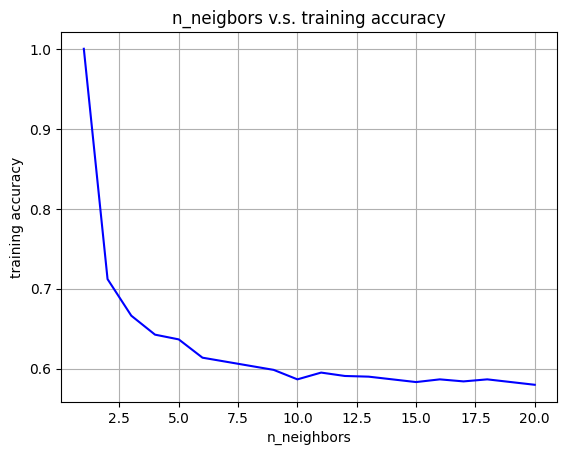

In [331]:
# Plot max_depth vs acc_train using max_depth_list and acc_train_list
plt.plot(n_neighbors_list, acc_train_list, "b")
plt.xlabel("n_neighbors")
plt.ylabel("training accuracy")
plt.title("n_neigbors v.s. training accuracy")
plt.grid(True)

In [332]:
# Find the best n_neighbors
n_neighbors_best = n_neighbors_list[np.argmax(acc_train_list)]

n_neighbors_best

1

#### Model Evaluation

In [336]:
kncbest = KNeighborsClassifier(n_neighbors=2)

In [337]:
kncbest.fit(X_train_fused, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

In [338]:
# Validate the model
y_test_pred_kncbest = kncbest.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_kncbest))

Test Accuracy: 0.41496598639455784


In [417]:
# Evaluate the model
accuracy_kncbest = accuracy_score(y_test, y_test_pred_kncbest)
conf_matrix_kncbest = confusion_matrix(y_test, y_test_pred_kncbest, labels=kncbest.classes_)
class_report_kncbest = classification_report(y_test, y_test_pred_kncbest)

# Print the evaluation results
print("Accuracy of the best KNN model:", accuracy_kncbest)
print("\nConfusion Matrix:\n", conf_matrix_kncbest)
print("\nClassification Report:\n", class_report_kncbest)

Accuracy of the best KNN model: 0.41496598639455784



Confusion Matrix:

 [[ 11  37   2   1   1   0]

 [ 51 109   3   0   2   0]

 [  4   4   0   1   0   0]

 [  7  15   0   0   0   0]

 [ 10  24   0   2   2   0]

 [  3   5   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.13      0.21      0.16        52

           1       0.56      0.66      0.61       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.40      0.05      0.09        38

           5       0.00      0.00      0.00         8



    accuracy                           0.41       294

   macro avg       0.18      0.15      0.14       294

weighted avg       0.39      0.41      0.38       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

### XGBoost

In [340]:
xgb = xgboost.XGBClassifier(objective="multi:softprob", random_state = 42)

In [341]:
xgb.fit(X_train_fused, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [342]:
y_test_pred_xgb = xgb.predict(X_test_fused)

In [416]:
# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)
class_report_xgb = classification_report(y_test, y_test_pred_xgb)

# Print the evaluation results
print("Accuracy of the XGB model:", accuracy_xgb)
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", class_report_xgb)

Accuracy of the XGB model: 0.6360544217687075



Confusion Matrix:

 [[ 23  27   0   0   2   0]

 [  9 154   1   0   1   0]

 [  1   7   0   0   1   0]

 [  2  10   2   8   0   0]

 [  4  32   0   0   2   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.59      0.44      0.51        52

           1       0.65      0.93      0.76       165

           2       0.00      0.00      0.00         9

           3       1.00      0.36      0.53        22

           4       0.33      0.05      0.09        38

           5       0.00      0.00      0.00         8



    accuracy                           0.64       294

   macro avg       0.43      0.30      0.32       294

weighted avg       0.59      0.64      0.57       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [344]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5), 
    "learning_rate": uniform(0, 0.5),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

In [346]:
search = RandomizedSearchCV(xgb, param_distributions = params, random_state = 42, n_iter = 5, cv = 3, verbose = 1, n_jobs = 1, return_train_score = True)

In [347]:
search.fit(X_train_fused, y_train.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2a86d6c80>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a86d4e20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2a86d6d40>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2a86d7340>},
                   random_state=42, return_train_score=True, verbose=1)

In [348]:
report_best_scores(search.cv_results_, 1)

Model with rank: 1

Mean validation score: 0.6525490499993541 (std: 0.006950179297733642)

Parameters: {'colsample_bytree': 0.8835558684167137, 'gamma': 0.06974693032602092, 'learning_rate': 0.14607232426760908, 'max_depth': 5, 'n_estimators': 114, 'subsample': 0.7824279936868144}




#### Model Evaluation

In [349]:
xgb_best = xgboost.XGBClassifier(objective="multi:softprob", random_state = 42, colsample_bytree = 0.8835558684167137, gamma = 0.06974693032602092, learning_rate = 0.14607232426760908, max_depth = 5, n_estimators = 114, subsample = 0.7824279936868144)

In [350]:
xgb_best.fit(X_train_fused, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8835558684167137, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.06974693032602092,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14607232426760908,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=114, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [351]:
y_test_pred_xgb_best = xgb_best.predict(X_test_fused)

In [415]:
# Evaluate the model
accuracy_xgb_best = accuracy_score(y_test, y_test_pred_xgb_best)
conf_matrix_xgb_best = confusion_matrix(y_test, y_test_pred_xgb_best)
class_report_xgb_best = classification_report(y_test, y_test_pred_xgb_best)

# Print the evaluation results
print("Accuracy of the best XGB model:", accuracy_xgb_best)
print("\nConfusion Matrix:\n", conf_matrix_xgb_best)
print("\nClassification Report:\n", class_report_xgb_best)

Accuracy of the best XGB model: 0.6326530612244898



Confusion Matrix:

 [[ 23  28   0   0   1   0]

 [  9 156   0   0   0   0]

 [  1   6   0   1   1   0]

 [  5  10   0   7   0   0]

 [  4  34   0   0   0   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.55      0.44      0.49        52

           1       0.64      0.95      0.77       165

           2       0.00      0.00      0.00         9

           3       0.88      0.32      0.47        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.63       294

   macro avg       0.34      0.28      0.29       294

weighted avg       0.52      0.63      0.55       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

## 3. AlexNet on image data

In [353]:
# Calculate class weights
img_class_weights = sklearn.utils.class_weight.compute_class_weight("balanced", classes=np.unique(img_data.train_ds.vocab), 
                                     y=img_data.train_ds.vocab)


In [354]:
# Set up image learner
img_learn_alexnet = vision_learner(img_data, alexnet,
                    pretrained=True,
                    loss_func=CrossEntropyLossFlat(weight=torch.tensor(img_class_weights, dtype=torch.float32)),
                    metrics=[accuracy, F1Score(average="macro")])

In [355]:
img_learn_alexnet.loss_func

FlattenedLoss of CrossEntropyLoss()

In [356]:
img_learn_alexnet.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

SuggestedLRs(valley=0.002511886414140463)

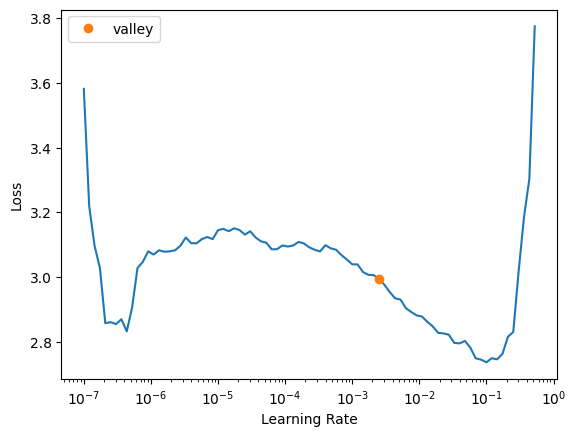

In [357]:
img_learn_alexnet.lr_find()

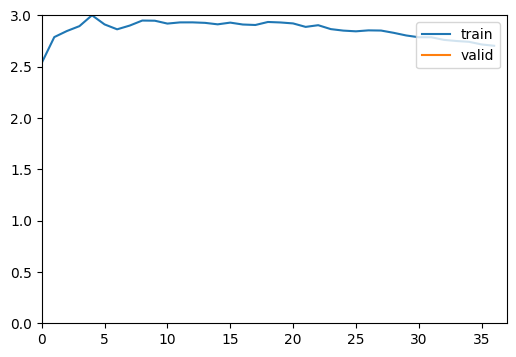

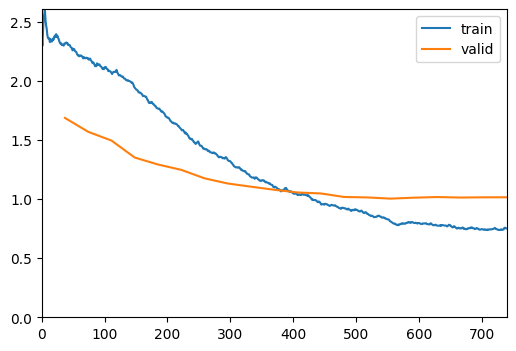

In [358]:
# Fine-tune the CNN on PAD-UFES-20 dataset
img_learn_alexnet.fine_tune(20, base_lr = 1e-3, cbs = [ShowGraphCallback(), SaveModelCallback(every_epoch=True, with_opt=True, fname = "alexnet")])

In [359]:
img_learn_alexnet.load("./alexnet_19")

#### Model evaluation

In [360]:
img_learn_alexnet.predict(f"./images/PAT_1516_1765_530.png")

('NEV',
 tensor(3),
 tensor([1.7752e-04, 1.6420e-05, 2.9572e-03, 9.9421e-01, 2.5770e-04, 2.3808e-03]))

In [361]:
tta_alexnet = img_learn_alexnet.tta(use_max=True)

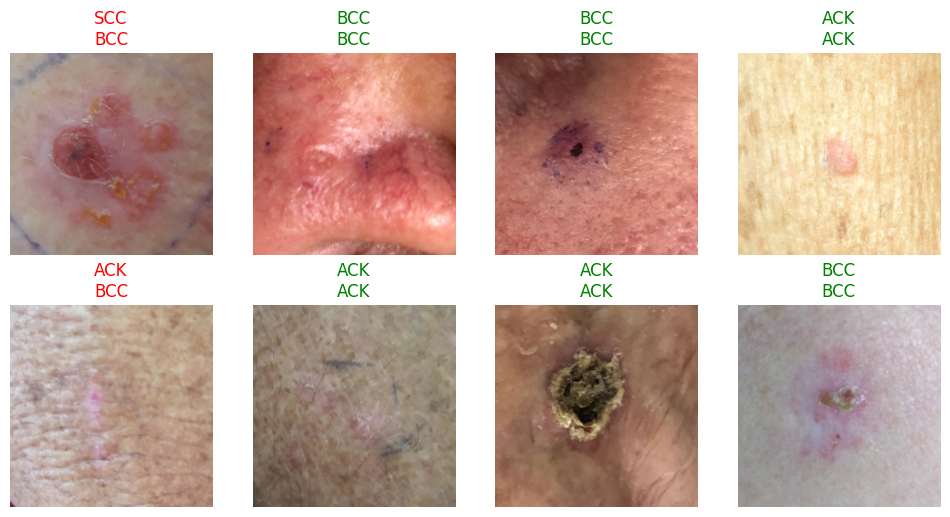

In [362]:
img_learn_alexnet.show_results(max_n=8)

In [363]:
interp_alexnet = Interpretation.from_learner(img_learn_alexnet)

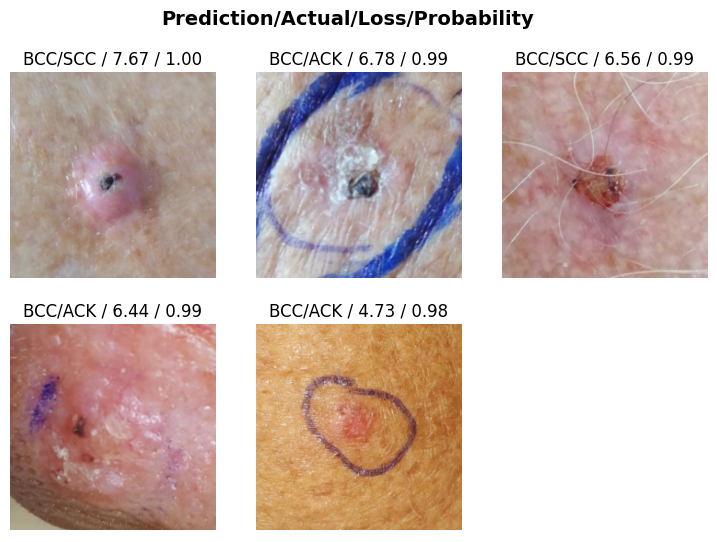

In [364]:
interp_alexnet.plot_top_losses(5)

In [365]:
c_interp_alexnet = ClassificationInterpretation.from_learner(img_learn_alexnet)

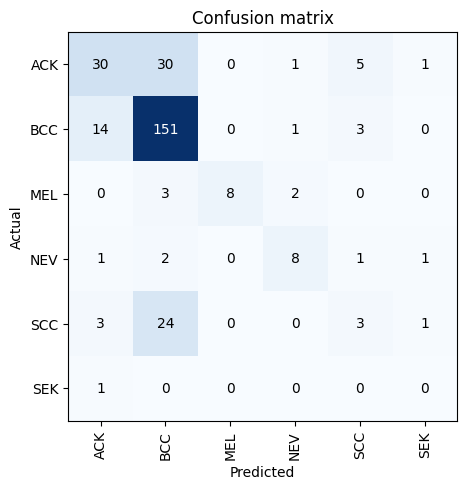

In [366]:
c_interp_alexnet.plot_confusion_matrix()

In [367]:
preds = img_learn_alexnet.get_preds()
pred_class = preds[0].max(1).indices
tgts = preds[1]

In [368]:
for i, name in enumerate(img_data.train.vocab):
    idx = torch.nonzero(tgts==i)
    subset = (tgts == pred_class)[idx]
    acc = subset.squeeze().float().mean()
    print(f'{name}: {acc:.1%}')

ACK: 44.8%

BCC: 89.3%

MEL: 61.5%

NEV: 61.5%

SCC: 9.7%

SEK: 0.0%


In [369]:
validation_metrics = img_learn_alexnet.validate()

In [370]:
acc = validation_metrics[1]
f1_score = validation_metrics[2]

acc, f1_score

(0.680272102355957, 0.4759191330038514)

#### Visualize the kernels of the first convolution layer

In [381]:
# Extract the weights of the first convolutional layer
first_layer_weights = img_learn_alexnet.model[0][0][0].weight.detach().cpu().numpy()

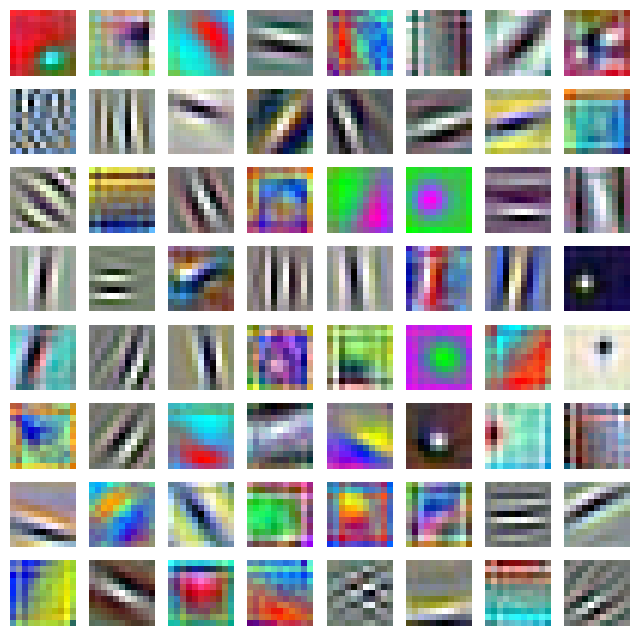

In [382]:
# Visualize the kernels
fig, axarr = plt.subplots(8, 8, figsize=(8, 8))

for i, ax in enumerate(axarr.flat):
    I = first_layer_weights[i, :, :, :]
    I = I.transpose(1, 2, 0)
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)
    I = (I - I_min)/(I_max-I_min)
    ax.imshow(I)
    ax.axis("off")
    
plt.show()

#### Visualize using GradCAM

In [383]:
model = img_learn_alexnet.model
model.eval()

model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (1): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_si

In [384]:
img = np.array(Image.open("./images/PAT_1516_1765_530.png"))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [385]:
# Define target_layers and targets
target_layers = [model[0][-1]]
targets = None

target_layers

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (1): ReLU(inplace=True)
   (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (4): ReLU(inplace=True)
   (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (7): ReLU(inplace=True)
   (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (9): ReLU(inplace=True)
   (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
 )]

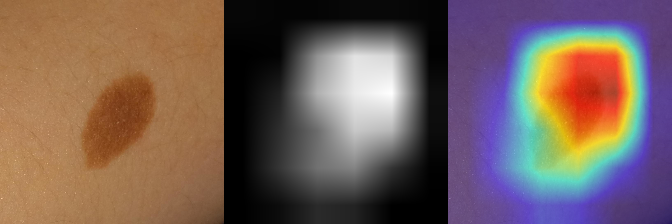

In [386]:
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

#### Visualize using EigenCAM

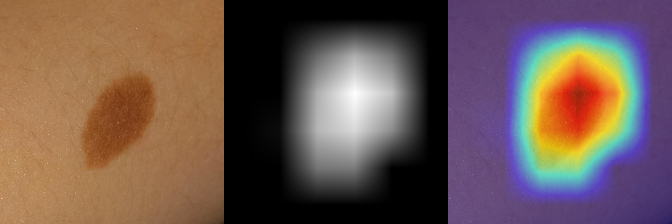

In [387]:
with EigenCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

#### Visualize using HiResCAM

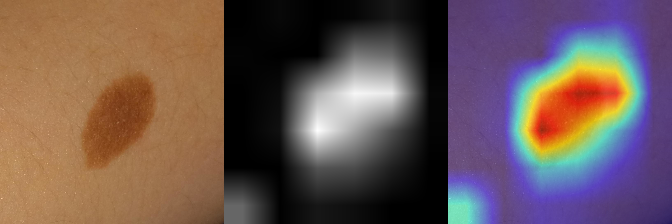

In [388]:
with HiResCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam, cam_image))
Image.fromarray(images)

### Feature Extraction

In [389]:
# Extract features from pre-trained CNN
hook_out = hook_output(img_learn_alexnet.model[0][-1], cpu = True)

In [390]:
# Get feature vector from CNN
def get_features(x):
    f = img_learn_alexnet.model.eval()(x)
    return hook_out.stored.numpy()

In [391]:
# Get features from images
def get_image_features(dl):
    features = []
    for xb, yb in dl:
        features.append(get_features(xb))
    return np.concatenate(features)

In [392]:
# Get features from images for train and test sets
train_image_features = get_image_features(img_data.train)
test_image_features = get_image_features(img_data.valid)

In [393]:
train_image_features.shape

(1180, 256, 6, 6)

In [394]:
# Flatten the image features
train_image_features_flat = train_image_features.reshape(train_image_features.shape[0], -1)
test_image_features_flat = test_image_features.reshape(test_image_features.shape[0], -1)

In [395]:
train_image_features_flat.shape

(1180, 9216)

In [396]:
# Remove the hook
hook_out.remove()

### Fuse tabular data and image features

In [397]:
X_train = tab_data.train_ds.xs
X_test = tab_data.valid_ds.xs
y_train = tab_data.train_ds.ys
y_test = tab_data.valid_ds.ys

In [398]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [399]:
X_train_scaled.shape, train_image_features_flat.shape

((1180, 21), (1180, 9216))

In [400]:
X_train_scaled.shape

(1180, 21)

In [401]:
# Fuse features from clinical attributes and images
X_train_fused = np.concatenate((X_train_scaled, train_image_features_flat), axis=1)
X_test_fused = np.concatenate((X_test_scaled, test_image_features_flat), axis=1)

In [402]:
X_train_fused.shape

(1180, 9237)

### Logistic Regression

In [403]:
LR = LogisticRegression(random_state=42, class_weight= "balanced", max_iter=5000)

In [404]:
LR.fit(X_train_fused, y_train.values.ravel())

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

In [405]:
# Validate the model
y_test_pred_LR = LR.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_LR))

Test Accuracy: 0.48639455782312924


In [406]:
# Evaluate the model
accuracy_LR = accuracy_score(y_test, y_test_pred_LR)
conf_matrix_LR = confusion_matrix(y_test, y_test_pred_LR, labels=LR.classes_)
class_report_LR = classification_report(y_test, y_test_pred_LR)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_LR)
print("\nConfusion Matrix:\n", conf_matrix_LR)
print("\nClassification Report:\n", class_report_LR)

Accuracy of the Logistic Regression model: 0.48639455782312924



Confusion Matrix:

 [[ 16  25   1   3   6   1]

 [ 21 124   3   2  14   1]

 [  3   3   0   1   2   0]

 [  5  13   0   1   2   1]

 [  6  30   0   0   2   0]

 [  4   4   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.29      0.31      0.30        52

           1       0.62      0.75      0.68       165

           2       0.00      0.00      0.00         9

           3       0.14      0.05      0.07        22

           4       0.08      0.05      0.06        38

           5       0.00      0.00      0.00         8



    accuracy                           0.49       294

   macro avg       0.19      0.19      0.19       294

weighted avg       0.42      0.49      0.45       294




#### Hyperparameter tuning

In [407]:
# Define parameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear", "newton-cg"],
                "penalty": [None, "l1", "l2"]}

In [408]:
# Define grid search
grid_search = RandomizedSearchCV(estimator = LR, param_distributions=log_reg_grid, n_iter = 20, cv=5)

In [409]:
grid_result = grid_search.fit(X_train_fused, y_train.values.ravel())

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/

In [410]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.568644 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 11.288378916846883}


#### Model Evaluation

In [411]:
bestLR = LogisticRegression(random_state=42, class_weight = "balanced", penalty="l1", solver="liblinear", C=11.288378916846883)

In [412]:
bestLR.fit(X_train_fused, y_train.values.ravel())

LogisticRegression(C=11.288378916846883, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [413]:
# Validate the model
y_test_pred_bestLR = bestLR.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_bestLR))

Test Accuracy: 0.4965986394557823


In [414]:
# Evaluate the model
accuracy_bestLR = accuracy_score(y_test, y_test_pred_bestLR)
conf_matrix_bestLR = confusion_matrix(y_test, y_test_pred_bestLR, labels=bestLR.classes_)
class_report_bestLR = classification_report(y_test, y_test_pred_bestLR)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_bestLR)
print("\nConfusion Matrix:\n", conf_matrix_bestLR)
print("\nClassification Report:\n", class_report_bestLR)

Accuracy of the Logistic Regression model: 0.4965986394557823



Confusion Matrix:

 [[ 22  23   0   0   6   1]

 [ 23 119   3   3  14   3]

 [  2   1   1   2   3   0]

 [  6   9   2   2   1   2]

 [  7  27   0   1   2   1]

 [  3   3   1   0   1   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.35      0.42      0.38        52

           1       0.65      0.72      0.69       165

           2       0.14      0.11      0.12         9

           3       0.25      0.09      0.13        22

           4       0.07      0.05      0.06        38

           5       0.00      0.00      0.00         8



    accuracy                           0.50       294

   macro avg       0.24      0.23      0.23       294

weighted avg       0.46      0.50      0.47       294




### Random Forest

In [419]:
RFC = RandomForestClassifier(n_estimators=20, class_weight="balanced", max_depth=20, random_state=42)

In [420]:
RFC.fit(X_train_fused, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=20,
                       random_state=42)

In [421]:
# Validate the model
y_test_pred_RFC = RFC.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_RFC))

Test Accuracy: 0.5510204081632653


In [422]:
# Evaluate the model
accuracy_RFC = accuracy_score(y_test, y_test_pred_RFC)
conf_matrix_RFC = confusion_matrix(y_test, y_test_pred_RFC, labels=RFC.classes_)
class_report_RFC = classification_report(y_test, y_test_pred_RFC)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_RFC)
print("\nConfusion Matrix:\n", conf_matrix_RFC)
print("\nClassification Report:\n", class_report_RFC)

Accuracy of the Random Forest model: 0.5510204081632653



Confusion Matrix:

 [[  2  50   0   0   0   0]

 [  4 160   0   0   1   0]

 [  0   9   0   0   0   0]

 [  1  21   0   0   0   0]

 [  0  38   0   0   0   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.29      0.04      0.07        52

           1       0.56      0.97      0.71       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.55       294

   macro avg       0.14      0.17      0.13       294

weighted avg       0.36      0.55      0.41       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [423]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [424]:
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RFC,  
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

In [425]:
np.random.seed(42)

rs_rf_best = rs_rf.fit(X_train_fused, y_train.values.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [426]:
rs_rf_best.best_params_

{'n_estimators': 910,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 10}

#### Model Evaluation

In [427]:
RFCbest = RandomForestClassifier(max_depth=10, class_weight="balanced", n_estimators=910, random_state=42, min_samples_split = 18, min_samples_leaf = 1)

In [428]:
RFCbest.fit(X_train_fused, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=18, n_estimators=910, random_state=42)

In [429]:
# Validate the model
y_test_pred_RFCbest = RFCbest.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_RFCbest))

Test Accuracy: 0.5884353741496599


In [430]:
# Evaluate the model
accuracy_RFCbest = accuracy_score(y_test, y_test_pred_RFCbest)
conf_matrix_RFCbest = confusion_matrix(y_test, y_test_pred_RFCbest, labels=RFCbest.classes_)
class_report_RFCbest = classification_report(y_test, y_test_pred_RFCbest)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_RFCbest)
print("\nConfusion Matrix:\n", conf_matrix_RFCbest)
print("\nClassification Report:\n", class_report_RFCbest)

Accuracy of the Random Forest model: 0.5884353741496599



Confusion Matrix:

 [[ 13  38   0   0   1   0]

 [  5 160   0   0   0   0]

 [  0   9   0   0   0   0]

 [  5  17   0   0   0   0]

 [  2  36   0   0   0   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.52      0.25      0.34        52

           1       0.60      0.97      0.74       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.59       294

   macro avg       0.19      0.20      0.18       294

weighted avg       0.43      0.59      0.47       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

### KNN

In [431]:
knc = KNeighborsClassifier(n_neighbors=5)

In [432]:
knc.fit(X_train_fused, y_train.values.ravel())

KNeighborsClassifier()

In [433]:
# Validate the model
y_test_pred_knc = knc.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_knc))

Test Accuracy: 0.47619047619047616


In [434]:
# Evaluate the model
accuracy_knc = accuracy_score(y_test, y_test_pred_knc)
conf_matrix_knc = confusion_matrix(y_test, y_test_pred_knc, labels=knc.classes_)
class_report_knc = classification_report(y_test, y_test_pred_knc)

# Print the evaluation results
print("Accuracy of the KNN model:", accuracy_knc)
print("\nConfusion Matrix:\n", conf_matrix_knc)
print("\nClassification Report:\n", class_report_knc)

Accuracy of the KNN model: 0.47619047619047616



Confusion Matrix:

 [[  8  41   0   2   1   0]

 [ 16 130   0   3  16   0]

 [  0   8   0   0   1   0]

 [  2  18   0   0   2   0]

 [  3  33   0   0   2   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.28      0.15      0.20        52

           1       0.55      0.79      0.65       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.09      0.05      0.07        38

           5       0.00      0.00      0.00         8



    accuracy                           0.48       294

   macro avg       0.15      0.17      0.15       294

weighted avg       0.37      0.48      0.41       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [435]:
# Create an array of possible n_neighbors
n_neighbors_list = np.arange(1, 21, 1)

n_neighbors_list

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [436]:
# Train a KNeighborsClassifier with n_neighbors in n_neighbors_list
acc_train_list=[]

for i in n_neighbors_list:
  clf = KNeighborsClassifier(n_neighbors=i)
  clf.fit(X_train_fused, y_train.values.ravel())

  Y_train_pred = clf.predict(X_train_fused)
  confusion_train = confusion_matrix(y_train, Y_train_pred)
  acc_train = accuracy_score(y_train, Y_train_pred)
  acc_train_list.append(acc_train)

In [437]:
for i in range(0, len(n_neighbors_list)):
  print(f"n_neighbor {n_neighbors_list[i]}| training accuracy: {acc_train_list[i]}")

n_neighbor 1| training accuracy: 1.0

n_neighbor 2| training accuracy: 0.7169491525423729

n_neighbor 3| training accuracy: 0.6822033898305084

n_neighbor 4| training accuracy: 0.6372881355932203

n_neighbor 5| training accuracy: 0.6203389830508474

n_neighbor 6| training accuracy: 0.6211864406779661

n_neighbor 7| training accuracy: 0.611864406779661

n_neighbor 8| training accuracy: 0.6008474576271187

n_neighbor 9| training accuracy: 0.5940677966101695

n_neighbor 10| training accuracy: 0.5957627118644068

n_neighbor 11| training accuracy: 0.5932203389830508

n_neighbor 12| training accuracy: 0.5889830508474576

n_neighbor 13| training accuracy: 0.5830508474576271

n_neighbor 14| training accuracy: 0.5872881355932204

n_neighbor 15| training accuracy: 0.5830508474576271

n_neighbor 16| training accuracy: 0.5805084745762712

n_neighbor 17| training accuracy: 0.5788135593220339

n_neighbor 18| training accuracy: 0.5779661016949152

n_neighbor 19| training accuracy: 0.576271186440678



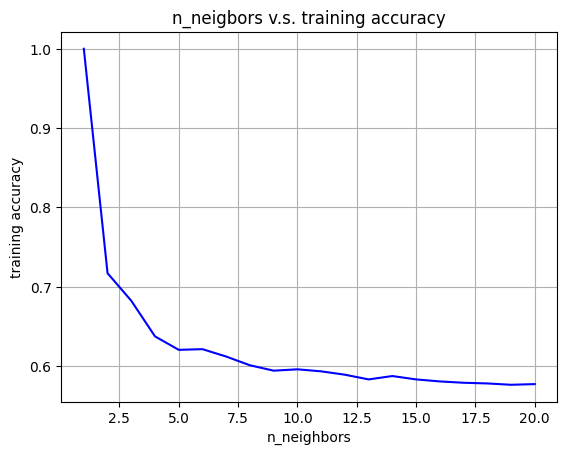

In [438]:
# Plot max_depth vs acc_train using max_depth_list and acc_train_list
plt.plot(n_neighbors_list, acc_train_list, "b")
plt.xlabel("n_neighbors")
plt.ylabel("training accuracy")
plt.title("n_neigbors v.s. training accuracy")
plt.grid(True)

In [439]:
# Find the best n_neighbors
n_neighbors_best = n_neighbors_list[np.argmax(acc_train_list)]

n_neighbors_best

1

#### Model Evaluation

In [451]:
kncbest = KNeighborsClassifier(n_neighbors=3)

In [452]:
kncbest.fit(X_train_fused, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=3)

In [453]:
# Validate the model
y_test_pred_kncbest = kncbest.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_kncbest))

Test Accuracy: 0.46938775510204084


In [454]:
# Evaluate the model
accuracy_kncbest = accuracy_score(y_test, y_test_pred_kncbest)
conf_matrix_kncbest = confusion_matrix(y_test, y_test_pred_kncbest, labels=kncbest.classes_)
class_report_kncbest = classification_report(y_test, y_test_pred_kncbest)

# Print the evaluation results
print("Accuracy of the KNN model:", accuracy_kncbest)
print("\nConfusion Matrix:\n", conf_matrix_kncbest)
print("\nClassification Report:\n", class_report_kncbest)

Accuracy of the KNN model: 0.46938775510204084



Confusion Matrix:

 [[ 18  31   0   1   2   0]

 [ 27 116   1   3  18   0]

 [  1   7   0   0   1   0]

 [  2  19   0   0   1   0]

 [  7  27   0   0   4   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.33      0.35      0.34        52

           1       0.56      0.70      0.62       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.15      0.11      0.12        38

           5       0.00      0.00      0.00         8



    accuracy                           0.47       294

   macro avg       0.17      0.19      0.18       294

weighted avg       0.39      0.47      0.42       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

### XGBoost

In [455]:
xgb = xgboost.XGBClassifier(objective="multi:softprob", random_state = 42)

In [456]:
xgb.fit(X_train_fused, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [458]:
y_test_pred_xgb = xgb.predict(X_test_fused)

In [467]:
# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)
class_report_xgb = classification_report(y_test, y_test_pred_xgb)

# Print the evaluation results
print("Accuracy of the XGB model:", accuracy_xgb)
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", class_report_xgb)

Accuracy of the XGB model: 0.6360544217687075



Confusion Matrix:

 [[ 22  29   0   0   1   0]

 [  9 156   0   0   0   0]

 [  1   6   1   1   0   0]

 [  8   7   1   6   0   0]

 [  3  34   0   0   1   0]

 [  0   7   0   0   0   1]]



Classification Report:

               precision    recall  f1-score   support



           0       0.51      0.42      0.46        52

           1       0.65      0.95      0.77       165

           2       0.50      0.11      0.18         9

           3       0.86      0.27      0.41        22

           4       0.50      0.03      0.05        38

           5       1.00      0.12      0.22         8



    accuracy                           0.64       294

   macro avg       0.67      0.32      0.35       294

weighted avg       0.63      0.64      0.56       294




#### Hyperparameter tuning

In [460]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5), 
    "learning_rate": uniform(0, 0.5),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

In [462]:
search = RandomizedSearchCV(xgb, param_distributions = params, random_state = 42, n_iter = 5, cv = 3, verbose = 1, n_jobs = 1, return_train_score = True)

In [463]:
search.fit(X_train_fused, y_train.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x334c2ac20>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x334c2bb80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x334c2bca0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x334c2ba30>},
                   random_state=42, return_train_score=True, verbose=1)

In [464]:
report_best_scores(search.cv_results_, 1)

Model with rank: 1

Mean validation score: 0.6466096623224534 (std: 0.004176691832600239)

Parameters: {'colsample_bytree': 0.8835558684167137, 'gamma': 0.06974693032602092, 'learning_rate': 0.14607232426760908, 'max_depth': 5, 'n_estimators': 114, 'subsample': 0.7824279936868144}




#### Model Evaluation

In [465]:
xgb_best = xgboost.XGBClassifier(objective="multi:softprob", random_state = 42, colsample_bytree = 0.8835558684167137, gamma = 0.06974693032602092, learning_rate = 0.14607232426760908, max_depth = 5, n_estimators = 114, subsample = 0.7824279936868144)

In [466]:
xgb_best.fit(X_train_fused, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8835558684167137, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.06974693032602092,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.14607232426760908,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=114, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [468]:
y_test_pred_xgb_best = xgb_best.predict(X_test_fused)

In [469]:
# Evaluate the model
accuracy_xgb_best = accuracy_score(y_test, y_test_pred_xgb_best)
conf_matrix_xgb_best = confusion_matrix(y_test, y_test_pred_xgb_best)
class_report_xgb_best = classification_report(y_test, y_test_pred_xgb_best)

# Print the evaluation results
print("Accuracy of the XGB model:", accuracy_xgb_best)
print("\nConfusion Matrix:\n", conf_matrix_xgb_best)
print("\nClassification Report:\n", class_report_xgb_best)

Accuracy of the XGB model: 0.6224489795918368



Confusion Matrix:

 [[ 20  32   0   0   0   0]

 [  8 157   0   0   0   0]

 [  0   8   1   0   0   0]

 [  7  10   0   5   0   0]

 [  3  35   0   0   0   0]

 [  1   7   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.51      0.38      0.44        52

           1       0.63      0.95      0.76       165

           2       1.00      0.11      0.20         9

           3       1.00      0.23      0.37        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.62       294

   macro avg       0.52      0.28      0.29       294

weighted avg       0.55      0.62      0.54       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

## 4. MobileNetV3_small on image data

In [514]:
# Calculate class weights
img_class_weights = sklearn.utils.class_weight.compute_class_weight("balanced", classes=np.unique(img_data.train_ds.vocab), 
                                     y=img_data.train_ds.vocab)


In [518]:
# Set up image learner
img_learn_mobile = vision_learner(img_data, mobilenet_v3_small,
                    weights=MobileNet_V3_Small_Weights.DEFAULT,
                    loss_func=CrossEntropyLossFlat(weight=torch.tensor(img_class_weights, dtype=torch.float32)),
                    metrics=[accuracy, F1Score(average="macro")])

In [519]:
img_learn_mobile.loss_func

FlattenedLoss of CrossEntropyLoss()

In [520]:
img_learn_mobile.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

SuggestedLRs(valley=0.002511886414140463)

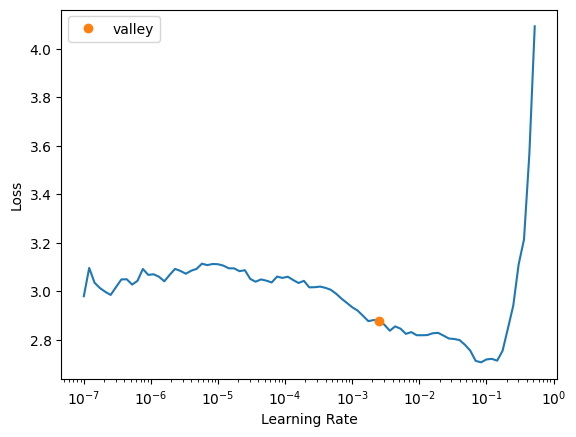

In [521]:
img_learn_mobile.lr_find()

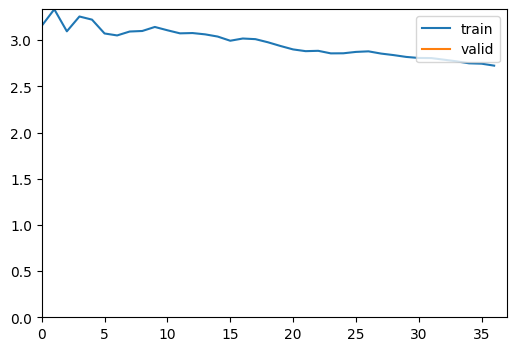

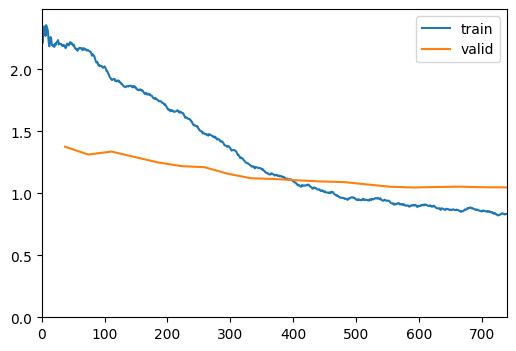

In [522]:
# Fine-tune the CNN on PAD-UFES-20 dataset
img_learn_mobile.fine_tune(20, base_lr = 1e-3, cbs = [ShowGraphCallback(), SaveModelCallback(every_epoch=True, with_opt=True, fname = "mobile")])

In [523]:
img_learn_mobile.load("./mobile_18")

#### Model evaluation

In [524]:
img_learn_mobile.predict(f"./images/PAT_1516_1765_530.png")

('NEV',
 tensor(3),
 tensor([2.2710e-04, 1.1120e-04, 1.1038e-03, 9.9763e-01, 1.5743e-04, 7.7294e-04]))

In [527]:
tta_mobile = img_learn_mobile.tta(use_max=True)

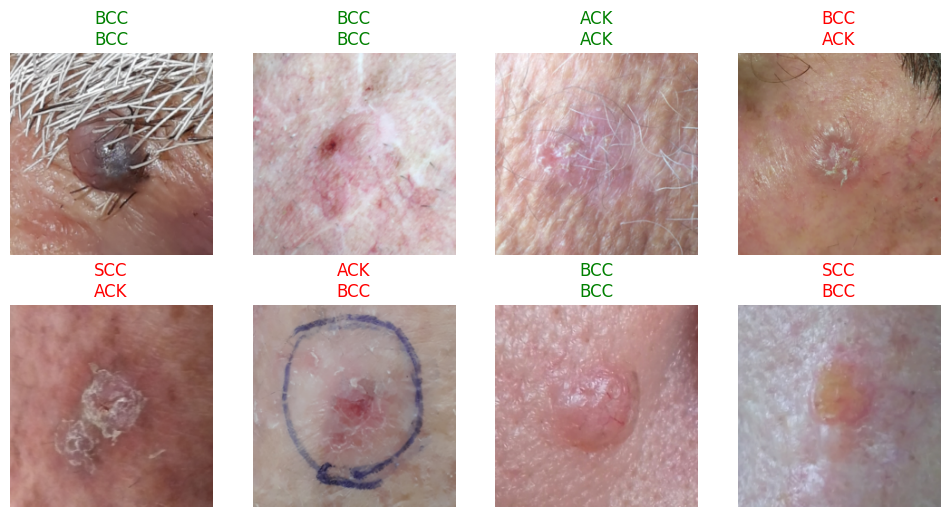

In [528]:
img_learn_mobile.show_results(max_n=8)

In [529]:
interp_mobile = Interpretation.from_learner(img_learn_mobile)

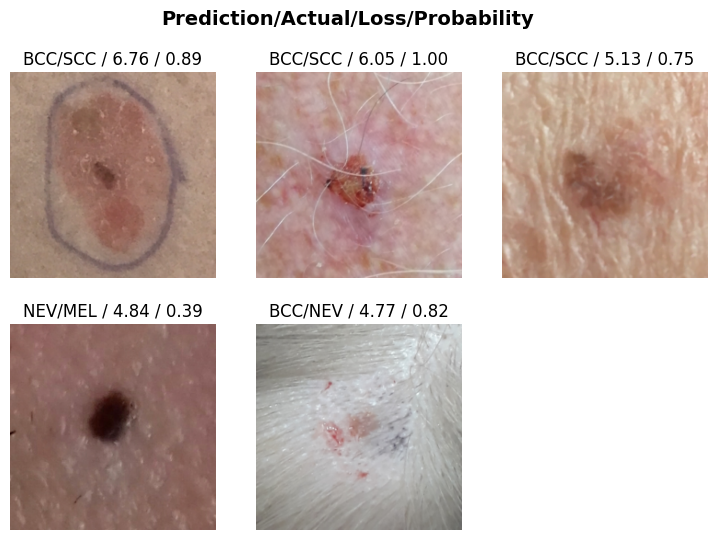

In [530]:
interp_mobile.plot_top_losses(5)

In [531]:
c_interp_mobile = ClassificationInterpretation.from_learner(img_learn_mobile)

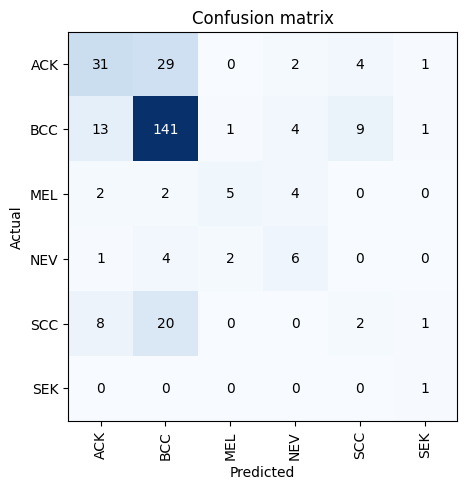

In [532]:
c_interp_mobile.plot_confusion_matrix()

In [533]:
preds = img_learn_mobile.get_preds()
pred_class = preds[0].max(1).indices
tgts = preds[1]

In [534]:
for i, name in enumerate(img_data.train.vocab):
    idx = torch.nonzero(tgts==i)
    subset = (tgts == pred_class)[idx]
    acc = subset.squeeze().float().mean()
    print(f'{name}: {acc:.1%}')

ACK: 46.3%

BCC: 83.4%

MEL: 38.5%

NEV: 46.2%

SCC: 6.5%

SEK: 100.0%


In [535]:
validation_metrics = img_learn_mobile.validate()

In [536]:
acc = validation_metrics[1]
f1_score = validation_metrics[2]

acc, f1_score

(0.6326530575752258, 0.4429565937358975)

#### Visualize the kernels of the first convolution layer

In [538]:
img_learn_mobile.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2dNormActivatio

In [540]:
# Extract the weights of the first convolutional layer
first_layer_weights = img_learn_mobile.model[0][0][0][0].weight.detach().cpu().numpy()

In [547]:
first_layer_weights.shape

(16, 3, 3, 3)

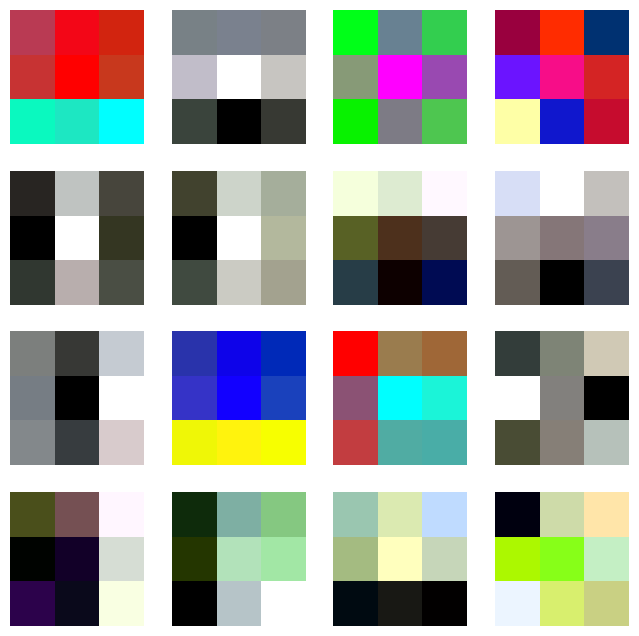

In [551]:
# Visualize the kernels
fig, axarr = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axarr.flat):
    I = first_layer_weights[i, :, :, :]
    I = I.transpose(1, 2, 0)
    I_max = I.max(axis=(0,1), keepdims=True)
    I_min = I.min(axis=(0,1), keepdims=True)
    I = (I - I_min)/(I_max-I_min)
    ax.imshow(I)
    ax.axis("off")
    
plt.show()

#### Visualize using GradCAM

In [552]:
model = img_learn_mobile.model
model.eval()

model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2dNormActivatio

In [553]:
img = np.array(Image.open("./images/PAT_1516_1765_530.png"))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [554]:
# Define target_layers and targets
target_layers = [model[0][-1]]
targets = None

target_layers

[Sequential(
   (0): Conv2dNormActivation(
     (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
     (2): Hardswish()
   )
   (1): InvertedResidual(
     (block): Sequential(
       (0): Conv2dNormActivation(
         (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
         (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
         (2): ReLU(inplace=True)
       )
       (1): SqueezeExcitation(
         (avgpool): AdaptiveAvgPool2d(output_size=1)
         (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
         (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
         (activation): ReLU()
         (scale_activation): Hardsigmoid()
       )
       (2): Conv2dNormActivation(
         (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (1): BatchN

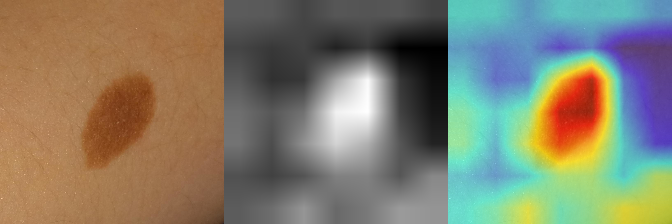

In [555]:
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

#### Visualize using EigenCAM

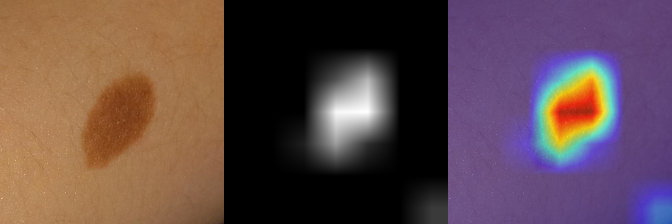

In [556]:
with EigenCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

#### Visualize using HiResCAM

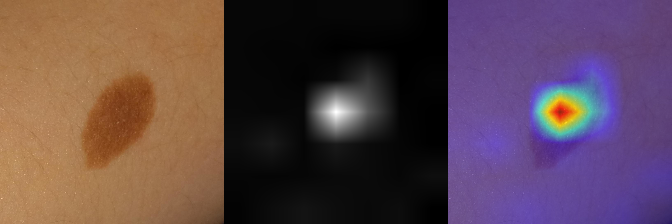

In [557]:
with HiResCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam, cam_image))
Image.fromarray(images)

### Feature Extraction

In [558]:
# Extract features from pre-trained CNN
hook_out = hook_output(img_learn_mobile.model[0][-1], cpu = True)

In [559]:
# Get feature vector from CNN
def get_features(x):
    f = img_learn_mobile.model.eval()(x)
    return hook_out.stored.numpy()

In [560]:
# Get features from images
def get_image_features(dl):
    features = []
    for xb, yb in dl:
        features.append(get_features(xb))
    return np.concatenate(features)

In [561]:
# Get features from images for train and test sets
train_image_features = get_image_features(img_data.train)
test_image_features = get_image_features(img_data.valid)

In [562]:
train_image_features.shape

(1180, 576, 7, 7)

In [563]:
# Flatten the image features
train_image_features_flat = train_image_features.reshape(train_image_features.shape[0], -1)
test_image_features_flat = test_image_features.reshape(test_image_features.shape[0], -1)

In [564]:
train_image_features_flat.shape

(1180, 28224)

In [565]:
# Remove the hook
hook_out.remove()

### Fuse tabular data and image features

In [566]:
X_train = tab_data.train_ds.xs
X_test = tab_data.valid_ds.xs
y_train = tab_data.train_ds.ys
y_test = tab_data.valid_ds.ys

In [567]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [568]:
X_train_scaled.shape, train_image_features_flat.shape

((1180, 21), (1180, 28224))

In [569]:
X_train_scaled.shape

(1180, 21)

In [570]:
# Fuse features from clinical attributes and images
X_train_fused = np.concatenate((X_train_scaled, train_image_features_flat), axis=1)
X_test_fused = np.concatenate((X_test_scaled, test_image_features_flat), axis=1)

In [571]:
X_train_fused.shape

(1180, 28245)

### Logistic Regression

In [572]:
LR = LogisticRegression(random_state=42, class_weight= "balanced", max_iter=5000)

In [573]:
LR.fit(X_train_fused, y_train.values.ravel())

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

In [574]:
# Validate the model
y_test_pred_LR = LR.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_LR))

Test Accuracy: 0.4931972789115646


In [575]:
# Evaluate the model
accuracy_LR = accuracy_score(y_test, y_test_pred_LR)
conf_matrix_LR = confusion_matrix(y_test, y_test_pred_LR, labels=LR.classes_)
class_report_LR = classification_report(y_test, y_test_pred_LR)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_LR)
print("\nConfusion Matrix:\n", conf_matrix_LR)
print("\nClassification Report:\n", class_report_LR)

Accuracy of the Logistic Regression model: 0.4931972789115646



Confusion Matrix:

 [[  4  43   0   1   4   0]

 [ 14 138   0   1  12   0]

 [  0   9   0   0   0   0]

 [  2  18   0   1   1   0]

 [  4  29   1   2   2   0]

 [  0   7   0   0   1   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.17      0.08      0.11        52

           1       0.57      0.84      0.67       165

           2       0.00      0.00      0.00         9

           3       0.20      0.05      0.07        22

           4       0.10      0.05      0.07        38

           5       0.00      0.00      0.00         8



    accuracy                           0.49       294

   macro avg       0.17      0.17      0.15       294

weighted avg       0.37      0.49      0.41       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [576]:
# Define parameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear", "newton-cg"],
                "penalty": [None, "l1", "l2"]}

In [577]:
# Define grid search
grid_search = RandomizedSearchCV(estimator = LR, param_distributions=log_reg_grid, n_iter = 20, cv=5)

In [578]:
grid_result = grid_search.fit(X_train_fused, y_train.values.ravel())

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters

  warnings.warn(

/Users/miche/Desktop/UM/Spring 2024/

In [579]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.538136 using {'solver': 'liblinear', 'penalty': 'l1', 'C': 4.281332398719396}


#### Model Evaluation

In [ ]:
bestLR = LogisticRegression(random_state=42, class_weight = "balanced", penalty="l1", solver="liblinear")

In [ ]:
bestLR.fit(X_train_fused, y_train.values.ravel())

LogisticRegression(class_weight='balanced', penalty='l1', random_state=42,
                   solver='liblinear')

In [ ]:
# Validate the model
y_test_pred_bestLR = bestLR.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_bestLR))

Test Accuracy: 0.5578231292517006


In [ ]:
# Evaluate the model
accuracy_bestLR = accuracy_score(y_test, y_test_pred_bestLR)
conf_matrix_bestLR = confusion_matrix(y_test, y_test_pred_bestLR, labels=bestLR.classes_)
class_report_bestLR = classification_report(y_test, y_test_pred_bestLR)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_bestLR)
print("\nConfusion Matrix:\n", conf_matrix_bestLR)
print("\nClassification Report:\n", class_report_bestLR)

Accuracy of the Logistic Regression model: 0.5578231292517006



Confusion Matrix:

 [[ 24  25   0   0   2   1]

 [ 19 134   2   0   9   1]

 [  1   4   2   1   1   0]

 [  6  13   0   2   1   0]

 [  7  27   2   0   2   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.42      0.46      0.44        52

           1       0.64      0.81      0.71       165

           2       0.33      0.22      0.27         9

           3       0.67      0.09      0.16        22

           4       0.13      0.05      0.08        38

           5       0.00      0.00      0.00         8



    accuracy                           0.56       294

   macro avg       0.36      0.27      0.28       294

weighted avg       0.51      0.56      0.51       294




### Random Forest

In [ ]:
RFC = RandomForestClassifier(n_estimators=20, class_weight="balanced", max_depth=20, random_state=42)

In [ ]:
RFC.fit(X_train_fused, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=20,
                       random_state=42)

In [ ]:
# Validate the model
y_test_pred_RFC = RFC.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_RFC))

Test Accuracy: 0.5578231292517006


In [ ]:
# Evaluate the model
accuracy_RFC = accuracy_score(y_test, y_test_pred_RFC)
conf_matrix_RFC = confusion_matrix(y_test, y_test_pred_RFC, labels=RFC.classes_)
class_report_RFC = classification_report(y_test, y_test_pred_RFC)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_RFC)
print("\nConfusion Matrix:\n", conf_matrix_RFC)
print("\nClassification Report:\n", class_report_RFC)

Accuracy of the Random Forest model: 0.5578231292517006



Confusion Matrix:

 [[ 15  37   0   0   0   0]

 [ 11 148   0   0   6   0]

 [  1   8   0   0   0   0]

 [  2  20   0   0   0   0]

 [  2  35   0   0   1   0]

 [  2   6   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.45      0.29      0.35        52

           1       0.58      0.90      0.71       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.14      0.03      0.04        38

           5       0.00      0.00      0.00         8



    accuracy                           0.56       294

   macro avg       0.20      0.20      0.18       294

weighted avg       0.43      0.56      0.46       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [ ]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [ ]:
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RFC2,  
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

In [ ]:
np.random.seed(42)

rs_rf_best = rs_rf.fit(X_train_pca, y_train.values.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
rs_rf_best.best_params_

{'n_estimators': 510,
 'min_samples_split': 14,
 'min_samples_leaf': 1,
 'max_depth': None}

#### Model Evaluation

In [ ]:
RFCbest = RandomForestClassifier(max_depth=max_depth_best, class_weight="balanced", n_estimators=20, random_state=42)

In [ ]:
RFCbest.fit(X_train_fused, y_train.values.ravel())

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=20,
                       random_state=42)

In [ ]:
# Validate the model
y_test_pred_RFCbest = RFCbest.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_RFCbest))

Test Accuracy: 0.5578231292517006


In [ ]:
# Evaluate the model
accuracy_RFCbest = accuracy_score(y_test, y_test_pred_RFCbest)
conf_matrix_RFCbest = confusion_matrix(y_test, y_test_pred_RFCbest, labels=RFCbest.classes_)
class_report_RFCbest = classification_report(y_test, y_test_pred_RFCbest)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_RFCbest)
print("\nConfusion Matrix:\n", conf_matrix_RFCbest)
print("\nClassification Report:\n", class_report_RFCbest)

Accuracy of the Random Forest model: 0.5578231292517006



Confusion Matrix:

 [[ 15  37   0   0   0   0]

 [ 11 148   0   0   6   0]

 [  1   8   0   0   0   0]

 [  2  20   0   0   0   0]

 [  2  35   0   0   1   0]

 [  2   6   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.45      0.29      0.35        52

           1       0.58      0.90      0.71       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.14      0.03      0.04        38

           5       0.00      0.00      0.00         8



    accuracy                           0.56       294

   macro avg       0.20      0.20      0.18       294

weighted avg       0.43      0.56      0.46       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

### KNN

In [ ]:
knc = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knc.fit(X_train_fused, y_train.values.ravel())

KNeighborsClassifier()

In [ ]:
# Validate the model
y_test_pred_knc = knc.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_knc))

Test Accuracy: 0.5544217687074829


In [ ]:
# Evaluate the model
accuracy_knc = accuracy_score(y_test, y_test_pred_knc)
conf_matrix_knc = confusion_matrix(y_test, y_test_pred_knc, labels=knc.classes_)
class_report_knc = classification_report(y_test, y_test_pred_knc)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_knc)
print("\nConfusion Matrix:\n", conf_matrix_knc)
print("\nClassification Report:\n", class_report_knc)

Accuracy of the Random Forest model: 0.5544217687074829



Confusion Matrix:

 [[  2  49   0   0   1   0]

 [  4 161   0   0   0   0]

 [  0   9   0   0   0   0]

 [  0  22   0   0   0   0]

 [  0  38   0   0   0   0]

 [  1   7   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.29      0.04      0.07        52

           1       0.56      0.98      0.71       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.55       294

   macro avg       0.14      0.17      0.13       294

weighted avg       0.37      0.55      0.41       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [ ]:
# Create an array of possible n_neighbors
n_neighbors_list = np.arange(1, 101, 11)

n_neighbors_list

array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100])

In [ ]:
# Train a KNeighborsClassifier with n_neighbors in n_neighbors_list
acc_train_list=[]

for i in n_neighbors_list:
  clf = KNeighborsClassifier(n_neighbors=i)
  clf.fit(X_train_fused, y_train.values.ravel())

  Y_train_pred = clf.predict(X_train_fused)
  confusion_train = confusion_matrix(y_train, Y_train_pred)
  acc_train = accuracy_score(y_train, Y_train_pred)
  acc_train_list.append(acc_train)

In [ ]:
for i in range(0, len(n_neighbors_list)):
  print(f"n_neighbor {n_neighbors_list[i]}| training accuracy: {acc_train_list[i]}")

n_neighbor 1| training accuracy: 1.0

n_neighbor 12| training accuracy: 0.5771186440677966

n_neighbor 23| training accuracy: 0.576271186440678

n_neighbor 34| training accuracy: 0.576271186440678

n_neighbor 45| training accuracy: 0.576271186440678

n_neighbor 56| training accuracy: 0.576271186440678

n_neighbor 67| training accuracy: 0.576271186440678

n_neighbor 78| training accuracy: 0.576271186440678

n_neighbor 89| training accuracy: 0.576271186440678

n_neighbor 100| training accuracy: 0.576271186440678


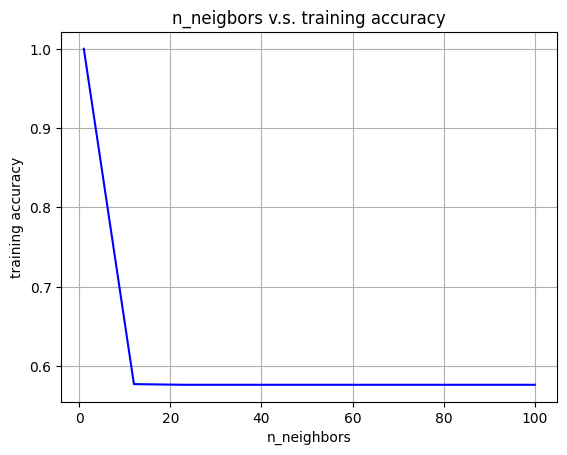

In [ ]:
# Plot max_depth vs acc_train using max_depth_list and acc_train_list
plt.plot(n_neighbors_list, acc_train_list, "b")
plt.xlabel("n_neighbors")
plt.ylabel("training accuracy")
plt.title("n_neigbors v.s. training accuracy")
plt.grid(True)

In [ ]:
# Find the best n_neighbors
n_neighbors_best = n_neighbors_list[np.argmax(acc_train_list)]

n_neighbors_best

1

#### Model Evaluation

In [ ]:
kncbest = KNeighborsClassifier(n_neighbors=12)

In [ ]:
kncbest.fit(X_train_fused, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=12)

In [ ]:
# Validate the model
y_test_pred_kncbest = kncbest.predict(X_test_fused)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_kncbest))

Test Accuracy: 0.5612244897959183


In [ ]:
# Evaluate the model
accuracy_kncbest = accuracy_score(y_test, y_test_pred_kncbest)
conf_matrix_kncbest = confusion_matrix(y_test, y_test_pred_kncbest, labels=kncbest.classes_)
class_report_kncbest = classification_report(y_test, y_test_pred_kncbest)

# Print the evaluation results
print("Accuracy of the Random Forest model:", accuracy_kncbest)
print("\nConfusion Matrix:\n", conf_matrix_kncbest)
print("\nClassification Report:\n", class_report_kncbest)

Accuracy of the Random Forest model: 0.5612244897959183



Confusion Matrix:

 [[  0  52   0   0   0   0]

 [  0 165   0   0   0   0]

 [  0   9   0   0   0   0]

 [  0  22   0   0   0   0]

 [  0  38   0   0   0   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.00      0.00      0.00        52

           1       0.56      1.00      0.72       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.56       294

   macro avg       0.09      0.17      0.12       294

weighted avg       0.31      0.56      0.40       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

### XGBoost

In [ ]:
import xgboost

In [ ]:
xgb = xgboost.XGBClassifier(objective="multi:softprob", random_state = 42)

In [ ]:
xgb.fit(X_train_fused, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_test_pred_xgb = xgb.predict(X_test_fused)

In [ ]:
# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)
class_report_xgb = classification_report(y_test, y_test_pred_xgb)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_xgb)
print("\nConfusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", class_report_xgb)

Accuracy of the Logistic Regression model: 0.6292517006802721



Confusion Matrix:

 [[ 19  33   0   0   0   0]

 [ 10 155   0   0   0   0]

 [  1   5   2   1   0   0]

 [  3   9   1   9   0   0]

 [  5  33   0   0   0   0]

 [  0   8   0   0   0   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.50      0.37      0.42        52

           1       0.64      0.94      0.76       165

           2       0.67      0.22      0.33         9

           3       0.90      0.41      0.56        22

           4       0.00      0.00      0.00        38

           5       0.00      0.00      0.00         8



    accuracy                           0.63       294

   macro avg       0.45      0.32      0.35       294

weighted avg       0.53      0.63      0.55       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

#### Hyperparameter tuning

In [ ]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5), 
    "learning_rate": uniform(0, 0.5),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

In [ ]:
search = RandomizedSearchCV(xgb, param_distributions = params, random_state = 42, n_iter = 20, cv = 3, verbose = 1, n_jobs = 1, return_train_score = True)

In [ ]:
search.fit(X_train_fused, y_train.values.ravel())

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
def report_best_scores(results, n_top = 3):
    for i in range(1, n_top +1):
        rank = np.flatnonzero(results["rank_test_score"] == i)
        for x in rank:
            print(f"Model with rank: {i}")
            print(f"Mean validation score: {results["mean_test_score"][x]} (std: {results["std_test_score"][x]})")
            print(f"Parameters: {results["params"][x]}")
            print("")

In [ ]:
report_best_scores(search.cv_results_, 1)

#### Model Evaluation

In [ ]:
xgb_best = xgboost.XGBClassifier(objective="multi:softprob", random_state = 42)

In [ ]:
xgb_best.fit(X_train_fused, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_test_pred_xgb_best = xgb_best.predict(X_test_pca)

In [ ]:
# Evaluate the model
accuracy_xgb_best = accuracy_score(y_test, y_test_pred_xgb_best)
conf_matrix_xgb_best = confusion_matrix(y_test, y_test_pred_xgb_best)
class_report_xgb_best = classification_report(y_test, y_test_pred_xgb_best)

# Print the evaluation results
print("Accuracy of the Logistic Regression model:", accuracy_xgb_best)
print("\nConfusion Matrix:\n", conf_matrix_xgb_best)
print("\nClassification Report:\n", class_report_xgb_best)

Accuracy of the Logistic Regression model: 0.5340136054421769



Confusion Matrix:

 [[  5  44   0   1   2   0]

 [  9 151   0   0   5   0]

 [  1   8   0   0   0   0]

 [  0  22   0   0   0   0]

 [  1  36   0   0   1   0]

 [  0   7   0   0   1   0]]



Classification Report:

               precision    recall  f1-score   support



           0       0.31      0.10      0.15        52

           1       0.56      0.92      0.70       165

           2       0.00      0.00      0.00         9

           3       0.00      0.00      0.00        22

           4       0.11      0.03      0.04        38

           5       0.00      0.00      0.00         8



    accuracy                           0.53       294

   macro avg       0.16      0.17      0.15       294

weighted avg       0.39      0.53      0.42       294




/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

/Users/miche/Desktop/UM/Spring 2024/CSC688 Digital Health/Project/data/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels wit

## Evaluation of Best Model

## Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
# # Compute permutation feature importance
# result = permutation_importance(rf, X, to.train.ys.values.flatten(), n_repeats=10, random_state=42)

In [ ]:
# # Get feature importance scores
# importance_scores = result.importances_mean

In [ ]:
# # Visualize feature importance scores
# plt.barh(to.train.xs.columns, importance_scores)
# plt.xlabel('Importance Score')
# plt.ylabel('Feature')
# plt.title('Feature Importance')
# plt.show()

## Feature Explainability with SHAP

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer(pd.DataFrame(X_test_fused, columns = X_test_fused.columns))

In [ ]:
# BCC class feature explanation
shap.plots.beeswarm(shap_values[..., 0])

In [ ]:
# ACK class feature explanation
shap.plots.beeswarm(shap_values[..., 1])

In [ ]:
# NEV class feature explanation
shap.plots.beeswarm(shap_values[..., 2])

In [ ]:
# SEK class feature explanation
shap.plots.beeswarm(shap_values[..., 3])

In [ ]:
# SCC class feature explanation
shap.plots.beeswarm(shap_values[..., 4])

In [ ]:
# MEL class feature explanation
shap.plots.beeswarm(shap_values[..., 5])